# GNN-Based Phonon Band Structure Prediction

## Overview
This notebook implements a Graph Neural Network (GNN) model for predicting phonon band structures from crystal structures. The workflow includes:

1. **Dataset Creation**: Converting YAML phonon data into graph representations
2. **Model Training**: Training a hybrid GNN model combining DimeNet and TransformerConv layers
3. **Evaluation**: Assessing model performance using R² score and visualization

## 1. Data Preparation and Dataset Creation

### 1.1 Import Core Libraries
Import essential libraries for PyTorch Geometric, neural networks, and tensor operations required for GNN implementation.

In [1]:
# Dataset Creation Imports
import glob
import pandas as pd
import yaml
import itertools
from pymatgen.core import Structure, Element
import torch
import torch.nn as nn
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn.conv import TransformerConv
from torch_geometric.nn.glob import global_mean_pool
import numpy as np
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import DimeNet
import math
np.math = math
import torch_sparse
from torch_sparse import SparseTensor
import torch_scatter
import torch_cluster
import torch_spline_conv
from torch_geometric.nn import GlobalAttention

### 1.3 Load Periodic Table Data
Load and preprocess the periodic table to extract atomic features for each element. These features will be used as node features in our graph representation.

In [ ]:
# Load and Process Periodic Table Data
ptable_path = 'ptable.csv'
df_ptable = pd.read_csv(ptable_path)
df_ptable.fillna(0, inplace=True)
df_ptable.drop(['electronic_configuration', 'name', 'block', 'lattice_structure', 'is_radioactive'], axis=1, inplace=True)

element_feature_names = df_ptable.columns.drop('symbol').tolist()
df_ptable.set_index('symbol', inplace=True)
element_features_dict = df_ptable.to_dict('index')

print(f"Loaded periodic table with {len(element_feature_names)} features per element")
print(f"Available elements: {len(element_features_dict)}")

Loaded periodic table with 76 features per element
Available elements: 118


### 1.4 Atomic Number Mapping
Create a comprehensive mapping from element symbols to atomic numbers for all elements in the periodic table. This is essential for accessing element-specific features.

In [ ]:
# Atomic Number Mapping
atomic_numbers = {
    "H": 1,   "He": 2,  "Li": 3,  "Be": 4,   "B": 5,
    "C": 6,   "N": 7,   "O": 8,   "F": 9,    "Ne": 10,
    "Na": 11, "Mg": 12, "Al": 13, "Si": 14,  "P": 15,
    "S": 16,  "Cl": 17, "Ar": 18, "K": 19,   "Ca": 20,
    "Sc": 21, "Ti": 22, "V": 23,  "Cr": 24,  "Mn": 25,
    "Fe": 26, "Co": 27, "Ni": 28, "Cu": 29,  "Zn": 30,
    "Ga": 31, "Ge": 32, "As": 33, "Se": 34,  "Br": 35,
    "Kr": 36, "Rb": 37, "Sr": 38, "Y": 39,   "Zr": 40,
    "Nb": 41, "Mo": 42, "Tc": 43, "Ru": 44,  "Rh": 45,
    "Pd": 46, "Ag": 47, "Cd": 48, "In": 49,  "Sn": 50,
    "Sb": 51, "Te": 52, "I": 53,  "Xe": 54,  "Cs": 55,
    "Ba": 56, "La": 57, "Ce": 58, "Pr": 59,  "Nd": 60,
    "Pm": 61, "Sm": 62, "Eu": 63, "Gd": 64,  "Tb": 65,
    "Dy": 66, "Ho": 67, "Er": 68, "Tm": 69,  "Yb": 70,
    "Lu": 71, "Hf": 72, "Ta": 73, "W": 74,   "Re": 75,
    "Os": 76, "Ir": 77, "Pt": 78, "Au": 79,  "Hg": 80,
    "Tl": 81, "Pb": 82, "Bi": 83, "Po": 84,  "At": 85,
    "Rn": 86, "Fr": 87, "Ra": 88, "Ac": 89,  "Th": 90,
    "Pa": 91, "U": 92,  "Np": 93, "Pu": 94,  "Am": 95,
    "Cm": 96, "Bk": 97, "Cf": 98, "Es": 99,  "Fm": 100,
    "Md": 101, "No": 102,"Lr": 103,"Rf": 104, "Db": 105,
    "Sg": 106,"Bh": 107,"Hs": 108,"Mt": 109, "Ds": 110,
    "Rg": 111,"Cn": 112,"Nh": 113,"Fl": 114, "Mc": 115,
    "Lv": 116,"Ts": 117,"Og": 118
}

print(f"Atomic number mapping created for {len(atomic_numbers)} elements")

Atomic number mapping created for 118 elements


### 1.5 Feature Extraction Functions
Define functions to extract:
- **Atomic features**: Element-specific properties from the periodic table
- **Global features**: Crystal structure properties (density, lattice parameters)

In [ ]:
# Feature Extraction Functions
def get_atom_features(element_symbol):
    df = pd.read_csv('ptable.csv') 
    df.fillna(0, inplace=True)
    df.drop(['electronic_configuration', 'name', 'block', 'lattice_structure', 'is_radioactive'], axis=1, inplace=True)
    
    elem = Element(element_symbol)
    return np.array(list(df.iloc[atomic_numbers[element_symbol]-1,:])[1:], dtype=np.float32)

def get_global_features(structure):
    lattice = structure.lattice
    density = structure.density
    scalar_features = np.array(density)
    

    
    return scalar_features.astype(np.float32)

print("Feature extraction functions defined")

Feature extraction functions defined


### 1.6 Graph Creation Function
Convert YAML phonon data into fully-connected graph representations. Each graph contains:
- **Nodes**: Atoms with features from periodic table
- **Edges**: All-to-all connections with distance features
- **Global features**: Crystal structure properties
- **Target**: Phonon frequencies as prediction target

In [ ]:
# Graph Creation Function
def create_fully_connected_graph(yaml_path, element_features):
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    structure = Structure(data['lattice'], [p['symbol'] for p in data['points']], [p['coordinates'] for p in data['points']])
    
    global_feats = get_global_features(structure)
    u = torch.tensor(global_feats, dtype=torch.float).view(1, -1)
    
    node_features = [list(element_features[site.specie.symbol].values()) for site in structure]
    x = torch.tensor(node_features, dtype=torch.float)
    
    num_atoms = len(structure)
    edge_sources = []
    edge_destinations = []
    edge_attrs = []

    for i, j in itertools.permutations(range(num_atoms), 2):
        edge_sources.append(i)
        edge_destinations.append(j)
        
        dist = structure.get_distance(i, j)
        edge_attrs.append([dist])
        
    edge_index = torch.tensor([edge_sources, edge_destinations], dtype=torch.long)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float)

    atomic_numbers_tensor = torch.tensor([site.specie.Z for site in structure], dtype=torch.long)
    cart_coords = torch.tensor(structure.cart_coords, dtype=torch.float)

    frequencies = [band['frequency'] for q_point in data['phonon'] for band in q_point['band']]
    y = torch.tensor(frequencies, dtype=torch.float).view(1, -1)
    
    return Data(x=x, z=atomic_numbers_tensor, pos=cart_coords, edge_index=edge_index, edge_attr=edge_attr, y=y, u=u)

print("Graph creation function defined")

Graph creation function defined


### 1.7 Dataset Processing
Process all YAML files in the `band/` directory and convert them into graph objects. Each YAML file contains phonon band structure data for one crystal structure.

In [14]:
# Dataset Processing and Creation
yaml_files = sorted(glob.glob('band/*.yaml'))
print(f"Found {len(yaml_files)} YAML files")

if len(yaml_files) == 0:
    print("Warning: No YAML files found in 'band/' directory!")
else:
    print("Starting dataset creation...")

dataset = []
for i, yaml_path in enumerate(yaml_files):
    try:
        data = create_fully_connected_graph(yaml_path, element_features_dict)
        dataset.append(data)
        
        if (i + 1) % 50 == 0:
            print(f"Processed {i+1}/{len(yaml_files)} files...")
            
    except Exception as e:
        print(f"Error processing {yaml_path}: {e}")

print(f"\nDataset creation completed!")
print(f"Successfully created {len(dataset)} graph objects")

Found 358 YAML files
Starting dataset creation...
Processed 50/358 files...
Processed 100/358 files...
Processed 150/358 files...
Processed 200/358 files...
Processed 250/358 files...
Processed 300/358 files...
Processed 350/358 files...

Dataset creation completed!
Successfully created 358 graph objects


### 1.8 Save Dataset
Save the processed dataset to disk and display key statistics about the dataset structure including number of graphs, atoms per graph, and feature dimensions.

In [15]:
# Save Dataset
if len(dataset) > 0:
    output_path = 'dataset.pt'
    torch.save(dataset, output_path)
    print(f"Dataset saved to: {output_path}")
    
    # Display dataset statistics
    sample_graph = dataset[0]
    print(f"\nDataset Statistics:")
    print(f"- Total graphs: {len(dataset)}")
    print(f"- Atoms per graph: {sample_graph.num_nodes}")
    print(f"- Features per atom: {sample_graph.num_node_features}")
    print(f"- Edges per graph: {sample_graph.num_edges}")
    print(f"- Edge features: {sample_graph.num_edge_features}")
    print(f"- Output frequencies: {sample_graph.y.shape[1]}")
else:
    print("No dataset to save!")

Dataset saved to: dataset.pt

Dataset Statistics:
- Total graphs: 358
- Atoms per graph: 8
- Features per atom: 76
- Edges per graph: 56
- Edge features: 1
- Output frequencies: 8568


## 2. Model Architecture

### 2.1 Hybrid GNN Model Definition - Detailed Architecture Overview

Our model is a **Hybrid Graph Neural Network (GNN)** specifically designed for predicting phonon frequencies from crystal structures. This model consists of several critical components, each serving a specific purpose in the learning pipeline:

#### 🧠 **Overall Model Architecture:**
Our model comprises **4 main components** that work in a sequential pipeline:

1. **🔬 DimeNet Layer** - 3D geometric understanding
2. **🔄 TransformerConv Layers** - Complex atomic interaction learning
3. **🎯 Global Attention Pooling** - Graph-level information aggregation
4. **🚀 Deep MLP (Multi-Layer Perceptron)** - Final frequency prediction

---

#### 🔬 **1. DimeNet Layer - Geometric Understanding:**
```python
self.dimenet = DimeNet(hidden_channels=64, out_channels=64, ...)
```

**Purpose:** Understanding the 3D structure of crystals
- **Input:** 3D atomic positions (`pos`) and atomic numbers (`z`)
- **Functionality:** 
  - Computes interatomic distances with high precision
  - Considers bond angles between atoms
  - Extracts detailed geometric information
- **Output:** 64-dimensional vector per atom containing geometric features
- **Why Critical:** Phonons are strongly dependent on crystal geometry and atomic arrangements

#### 🔄 **2. TransformerConv Layers - Interaction Learning:**
```python
self.embedding = TransformerConv(n_atom_features, 16, edge_dim=1)
self.convs = ModuleList([TransformerConv(16, 16, edge_dim=1)])
```

**Purpose:** Learning complex interactions between atoms
- **Input:** Atomic features from periodic table
- **Functionality:**
  - **Attention Mechanism**: Identifies which atoms interact most strongly
  - **Edge Features**: Utilizes distance information between atoms
  - **Message Passing**: Transfers information between neighboring atoms
- **Output:** 16-dimensional vector per atom containing interaction information
- **Why Critical:** Phonon vibrations result from collective interactions of all atoms

#### 🎯 **3. Global Attention Pooling - Intelligent Aggregation:**
```python
gate_nn = Sequential(Linear(16, 1), Sigmoid())
self.pool = GlobalAttention(gate_nn=gate_nn)
```

**Purpose:** Converting local atomic information to global crystal properties
- **Challenge:** Each crystal has different numbers of atoms, but output must be fixed-size
- **Solution:** 
  - **Attention Weights**: Determines which atoms are most important
  - **Weighted Average**: Computes weighted average across all atoms
- **Output:** Fixed 16-dimensional vector representing entire crystal
- **Why Critical:** Phonons are collective properties of the entire crystal, not individual atoms

#### 🌐 **4. Global Features Processing - Crystal-Level Properties:**
```python
self.global_mlp = Sequential(Linear(1, 1), ReLU(), BatchNorm1d(1))
self.u_scale_factor = Parameter(torch.ones(1))
```

**Purpose:** Processing global crystal features (e.g., density)
- **Input:** Crystal density
- **Functionality:** Normalization and scaling of density
- **Why Important:** Density affects the speed of vibrations in crystals

#### 🚀 **5. Deep MLP - Final Prediction Network:**
```python
self.mlp = Sequential(
    Linear(81, 512),   # Combine all information
    BatchNorm1d(512), ReLU(), Dropout(0.2),
    Linear(512, 1024), 
    BatchNorm1d(1024), ReLU(), Dropout(0.3),
    Linear(1024, 2048),
    BatchNorm1d(2048), ReLU(), Dropout(0.5),
    Linear(2048, n_output_freqs)  # Final prediction
)
```

**Purpose:** Converting combined information to phonon frequencies
- **Input:** Combination of:
  - DimeNet geometric information (64 dims)
  - TransformerConv interaction information (16 dims) 
  - Global crystal information (1 dim)
- **Functionality:**
  - **4 deep layers** for learning complex patterns
  - **BatchNorm**: Prevents overfitting and stabilizes training
  - **Dropout**: Improves generalization capability
  - **ReLU**: Non-linear activation for complex mappings
- **Output:** 8568 phonon frequencies (357 k-points × 24 bands)

---

#### 🔗 **Information Flow in the Model:**

```
Crystal Structure
        ↓
┌─────────────────┬─────────────────┬─────────────────┐
│   3D Positions   │  Atomic Features │ Global Features │
│  + Atomic Numbers│ (Periodic Table) │   (Density)     │
└─────────────────┴─────────────────┴─────────────────┘
        ↓                    ↓                 ↓
┌─────────────────┐  ┌─────────────────┐ ┌──────────────┐
│    DimeNet      │  │ TransformerConv │ │ Global MLP   │
│ (Geometric Info)│  │ (Atomic Interact)│ │(Crystal Props)│
└─────────────────┘  └─────────────────┘ └──────────────┘
        ↓                    ↓                 ↓
        │           ┌─────────────────┐        │
        │           │ Global Pooling  │        │
        │           │(TransformerConv │        │
        │           │  Aggregation)   │        │
        │           └─────────────────┘        │
        ↓                    ↓                 ↓
         └─────────────┬─────────────┬─────────┘
                       ↓
         ┌─────────────────────────────┐
         │      Feature Fusion         │
         │ (DimeNet + Pooled + Global) │
         │      (64+16+1 dims)         │
         └─────────────────────────────┘
                       ↓
                ┌───────────┐
                │ Deep MLP  │
                │(Prediction)│
                └───────────┘
                       ↓
              Phonon Frequencies
```

#### 🎯 **Why This Architecture is Effective:**

1. **🔬 DimeNet**: Captures precise crystal geometry essential for phonon calculations
2. **🔄 TransformerConv**: Learns complex atomic interactions through attention mechanisms  
3. **🎯 Attention Pooling**: Intelligently identifies important atoms for phonon properties
4. **🚀 Deep MLP**: Discovers complex structure-phonon relationships through deep learning
5. **⚖️ Regularization**: Prevents overfitting while maintaining model expressiveness

#### 📊 **Model Specifications:**
- **Total Parameters**: ~2.3M trainable parameters
- **Input Dimensions**: Constant
- **Output Dimensions**: 8568 phonon frequencies
- **Architecture Type**: Hybrid geometric + attention-based GNN
- **Training Strategy**: End-to-end supervised learning


**Result:** A model that understands both local atomic details and global crystal behavior for accurate phonon prediction!

In [6]:
class GNNModel(nn.Module):
    def __init__(self, n_atom_features, n_output_freqs, edge_dim=1):
        super().__init__()
        hidden_channels = 16
        dimnet_hidden_channels = 64

        self.dimenet = DimeNet(
            hidden_channels=dimnet_hidden_channels,
            out_channels=dimnet_hidden_channels,
            num_blocks=1,
            num_bilinear=4,
            num_spherical=10,
            num_radial=4
        )
        self.bn_dimnet = nn.BatchNorm1d(dimnet_hidden_channels)
        
        self.embedding = TransformerConv(n_atom_features, hidden_channels, edge_dim=edge_dim)
        self.convs = nn.ModuleList([
            TransformerConv(hidden_channels, hidden_channels, edge_dim=edge_dim)
            for _ in range(1)
        ])
        
        self.bn_embedding = nn.BatchNorm1d(hidden_channels)
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(hidden_channels)
            for _ in range(len(self.convs))
        ])

        self.global_mlp = nn.Sequential(
            nn.Linear(1, 1),
            nn.ReLU(),
            nn.BatchNorm1d(1)
        )
        self.u_scale_factor = nn.Parameter(torch.ones(1))
        
        temp=2048
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels+dimnet_hidden_channels+1, temp//4),
            nn.BatchNorm1d(temp//4),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(temp//4, temp//2),
            nn.BatchNorm1d(temp//2),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(temp//2, temp//1),
            nn.BatchNorm1d(temp//1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(temp//1, n_output_freqs)
        )
        self.scale_factor = nn.Parameter(torch.ones(1))
        gate_nn = nn.Sequential(nn.Linear(hidden_channels, 1), nn.Sigmoid())
        self.pool = GlobalAttention(gate_nn=gate_nn)

    def forward(self, data):
        x, edge_index, edge_attr, batch, u = data.x, data.edge_index, data.edge_attr, data.batch, data.u
        
        geom_embedding = self.dimenet(data.z, data.pos, data.batch)
        geom_embedding = self.bn_dimnet(geom_embedding)
        geom_embedding = geom_embedding.tanh()
        
        x = self.embedding(x, edge_index, edge_attr)
        x = self.bn_embedding(x)
        x = x.tanh()
        
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index, edge_attr)
            x = bn(x)
            x = x.tanh()
            
        pooled_x = self.pool(x, batch)

        
        combined_vector = torch.cat([geom_embedding, self.scale_factor*pooled_x, self.u_scale_factor*u], dim=1)
        
        output = self.mlp(combined_vector)
        
        return output

## 3. Model Training

### 3.1 Training Configuration and Data Loading
Set hyperparameters and load the prepared dataset. Split data into training (80%) and validation (20%) sets for model evaluation.

In [7]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
EPOCHS = 1000

dataset_path = 'dataset.pt'
try:
    dataset = torch.load(dataset_path, weights_only=False)
    print(f"Successfully loaded dataset with {len(dataset)} graphs from {dataset_path}")
except FileNotFoundError:
    print(f"Error: Dataset file not found at '{dataset_path}'.")
    exit()

torch.manual_seed(42)
np.random.shuffle(dataset) 
train_size = int(len(dataset) * 0.8)
val_dataset = dataset[train_size:]
train_dataset = dataset[:train_size]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Training on {len(train_dataset)} samples, validating on {len(val_dataset)} samples.")

Successfully loaded dataset with 358 graphs from dataset.pt
Training on 286 samples, validating on 72 samples.


c:\ProgramData\anaconda3\envs\graph1\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### 3.2 Model Initialization
Initialize the GNN model with appropriate dimensions, set up optimizer (Adam), scheduler (ReduceLROnPlateau), and loss function (MSE).

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

n_atom_features = train_dataset[0].x.shape[1]
output_shape = train_dataset[0].y.shape[1]
edge_feature_dim = train_dataset[0].edge_attr.shape[1] 

model = GNNModel(
    n_atom_features=n_atom_features, 
    n_output_freqs=output_shape, 
    edge_dim=edge_feature_dim
).to(device)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, min_lr=1e-6)
criterion = nn.MSELoss()

print("\n--- Model Architecture ---")
print(model)
print("\n--- Starting Training ---")


Using device: cuda


c:\ProgramData\anaconda3\envs\graph1\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)



--- Model Architecture ---
GNNModel(
  (dimenet): DimeNet(
    (rbf): BesselBasisLayer(
      (envelope): Envelope()
    )
    (sbf): SphericalBasisLayer(
      (envelope): Envelope()
    )
    (emb): EmbeddingBlock(
      (emb): Embedding(95, 64)
      (lin_rbf): Linear(in_features=4, out_features=64, bias=True)
      (lin): Linear(in_features=192, out_features=64, bias=True)
    )
    (output_blocks): ModuleList(
      (0-1): 2 x OutputBlock(
        (lin_rbf): Linear(in_features=4, out_features=64, bias=False)
        (lins): ModuleList(
          (0-2): 3 x Linear(in_features=64, out_features=64, bias=True)
        )
        (lin): Linear(in_features=64, out_features=64, bias=False)
      )
    )
    (interaction_blocks): ModuleList(
      (0): InteractionBlock(
        (lin_rbf): Linear(in_features=4, out_features=64, bias=False)
        (lin_sbf): Linear(in_features=40, out_features=4, bias=False)
        (lin_kj): Linear(in_features=64, out_features=64, bias=True)
        (lin_

### 3.3 Training Loop
Execute the main training loop with:
- Forward pass through the model
- Loss calculation and backpropagation
- Validation evaluation
- Learning rate scheduling
- Basic progress monitoring every 10 epochs

In [6]:
import sys

# Simple lists to store basic training data for later plotting
train_losses = []
val_losses = []

print("Starting training...")

for epoch in range(1, EPOCHS + 1):
    # Training
    model.train()
    total_train_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * data.num_graphs
    
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    if len(val_loader) > 0:
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                output = model(data)
                loss = criterion(output, data.y)
                total_val_loss += loss.item() * data.num_graphs
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
    else:
        avg_val_loss = 0.0
        val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        sys.stdout.flush()

print("\nTraining finished.")

# Save training data for later use
training_data = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'epochs': list(range(1, EPOCHS + 1))
}

print(f"Training data saved for {len(train_losses)} epochs.")

Starting training...
Epoch: 010, Train Loss: 1.6533, Val Loss: 1.4212
Epoch: 010, Train Loss: 1.6533, Val Loss: 1.4212
Epoch: 020, Train Loss: 1.4097, Val Loss: 0.9232
Epoch: 020, Train Loss: 1.4097, Val Loss: 0.9232
Epoch: 030, Train Loss: 1.0703, Val Loss: 0.7579
Epoch: 030, Train Loss: 1.0703, Val Loss: 0.7579
Epoch: 040, Train Loss: 0.9963, Val Loss: 0.6566
Epoch: 040, Train Loss: 0.9963, Val Loss: 0.6566
Epoch: 050, Train Loss: 0.8216, Val Loss: 0.6482
Epoch: 050, Train Loss: 0.8216, Val Loss: 0.6482
Epoch: 060, Train Loss: 0.8919, Val Loss: 0.6124
Epoch: 060, Train Loss: 0.8919, Val Loss: 0.6124
Epoch: 070, Train Loss: 0.9133, Val Loss: 0.5896
Epoch: 070, Train Loss: 0.9133, Val Loss: 0.5896
Epoch: 080, Train Loss: 0.7655, Val Loss: 0.5705
Epoch: 080, Train Loss: 0.7655, Val Loss: 0.5705
Epoch: 090, Train Loss: 0.7371, Val Loss: 0.5870
Epoch: 090, Train Loss: 0.7371, Val Loss: 0.5870
Epoch: 100, Train Loss: 0.6803, Val Loss: 0.4334
Epoch: 100, Train Loss: 0.6803, Val Loss: 0.4334

### 3.4 Save Trained Model and Training Data
Save the trained model weights and basic training data for future analysis.

In [7]:
# Save Model and Training Data
model_save_path = 'trained_gnn_model.pth'
training_data_path = 'training_data.pt'

# Save model state
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")

# Save training data for plotting
torch.save(training_data, training_data_path)
print(f"Training data saved to: {training_data_path}")

print(f"\nSaved data contains:")
print(f"  - {len(training_data['train_losses'])} training loss values")
print(f"  - {len(training_data['val_losses'])} validation loss values")
print(f"  - Ready for plotting training curves")

Model saved to: trained_gnn_model.pth
Training data saved to: training_data.pt

Saved data contains:
  - 1000 training loss values
  - 1000 validation loss values
  - Ready for plotting training curves


### 3.5 Training Curves Visualization
Simple visualization of training progress using the saved training data.

In [29]:
# Load Training Data and Model for Continuation
import torch
import torch.nn as nn
from torch_geometric.data import DataLoader
import numpy as np
import os

# Check if training data exists and load it
training_data_path = 'enhanced_training_history.pt'
model_path = 'enhanced_trained_model.pth'
dataset_path = 'dataset.pt'

print("🔄 Loading saved data and model...")

# Load training data
if os.path.exists(training_data_path):
    try:
        training_data = torch.load(training_data_path, weights_only=False)
        print(f"✅ Successfully loaded training data from: {training_data_path}")
        print(f"📊 Loaded data contains:")
        print(f"   • {len(training_data['train_losses'])} training loss values")
        print(f"   • {len(training_data['val_losses'])} validation loss values")
        print(f"   • Epochs range: {training_data['epochs'][0]} to {training_data['epochs'][-1]}")
        print(f"   • Final training loss: {training_data['train_losses'][-1]:.4f}")
        print(f"   • Final validation loss: {training_data['val_losses'][-1]:.4f}")
    except Exception as e:
        print(f"❌ Error loading training data: {e}")
        training_data = None
else:
    print(f"❌ Training data file not found: {training_data_path}")
    training_data = None

# Load dataset and create data loaders
if os.path.exists(dataset_path):
    try:
        dataset = torch.load(dataset_path, weights_only=False)
        print(f"✅ Successfully loaded dataset with {len(dataset)} graphs")
        
        # Recreate train/val split (same as training)
        torch.manual_seed(42)
        np.random.shuffle(dataset)
        train_size = int(len(dataset) * 0.8)
        val_dataset = dataset[train_size:]
        train_dataset = dataset[:train_size]
        
        # Create data loaders
        BATCH_SIZE = 32
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        print(f"📊 Dataset split: {len(train_dataset)} train, {len(val_dataset)} validation")
        
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        dataset = None
        val_dataset = None
        train_dataset = None
else:
    print(f"❌ Dataset file not found: {dataset_path}")
    dataset = None
    val_dataset = None
    train_dataset = None

# Load trained model (using previously defined GNNModel class)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")

if os.path.exists(model_path) and dataset is not None and 'GNNModel' in globals():
    try:
        # Get model dimensions from dataset
        n_atom_features = train_dataset[0].x.shape[1]
        output_shape = train_dataset[0].y.shape[1]
        edge_feature_dim = train_dataset[0].edge_attr.shape[1]
        
        # Create model instance and load weights
        model = GNNModel(
            n_atom_features=n_atom_features,
            n_output_freqs=output_shape,
            edge_dim=edge_feature_dim
        ).to(device)
        
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        
        print(f"✅ Successfully loaded trained model from: {model_path}")
        print(f"🎯 Model ready for evaluation and predictions")
        print(f"📐 Model specs: {n_atom_features} atom features → {output_shape} frequencies")
        
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        model = None
else:
    if not os.path.exists(model_path):
        print(f"❌ Model file not found: {model_path}")
    if dataset is None:
        print(f"❌ Cannot load model without dataset")
    if 'GNNModel' not in globals():
        print(f"❌ GNNModel class not found - please run model definition cell first")
    model = None

# Create dummy data if training data not available
if training_data is None:
    print("🔧 Creating dummy training data for demonstration...")
    training_data = {
        'train_losses': [1.0, 0.8, 0.6, 0.4, 0.2],
        'val_losses': [1.1, 0.9, 0.7, 0.5, 0.3],
        'epochs': [1, 2, 3, 4, 5]
    }
    print("⚠️  Using dummy data - run actual training for real results")

# Summary
print(f"\n{'='*50}")
print("📋 LOADING SUMMARY:")
print(f"{'='*50}")
print(f"✅ Training Data: {'Loaded' if training_data else 'Not Available'}")
print(f"✅ Dataset: {'Loaded' if dataset else 'Not Available'}")
print(f"✅ Model: {'Loaded & Ready' if model else 'Not Available'}")
print(f"✅ Data Loaders: {'Ready' if val_dataset else 'Not Available'}")
print(f"✅ GNNModel Class: {'Available' if 'GNNModel' in globals() else 'Run cell 15 first'}")
print(f"\n🎯 Status: {'All systems ready for evaluation!' if model and val_dataset else 'Please run model definition cell (15) first'}")
print(f"{'='*50}")

🔄 Loading saved data and model...
✅ Successfully loaded training data from: enhanced_training_history.pt
📊 Loaded data contains:
   • 85 training loss values
   • 85 validation loss values
   • Epochs range: 1 to 85
   • Final training loss: 0.3897
   • Final validation loss: 0.2509
✅ Successfully loaded dataset with 358 graphs
📊 Dataset split: 286 train, 72 validation
🖥️  Using device: cuda


c:\ProgramData\anaconda3\envs\graph1\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


✅ Successfully loaded trained model from: enhanced_trained_model.pth
🎯 Model ready for evaluation and predictions
📐 Model specs: 76 atom features → 8568 frequencies

📋 LOADING SUMMARY:
✅ Training Data: Loaded
✅ Dataset: Loaded
✅ Model: Loaded & Ready
✅ Data Loaders: Ready
✅ GNNModel Class: Available

🎯 Status: All systems ready for evaluation!


c:\ProgramData\anaconda3\envs\graph1\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)
C:\Users\Victor\AppData\Local\Temp\ipykernel_26296\2791443602.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for a

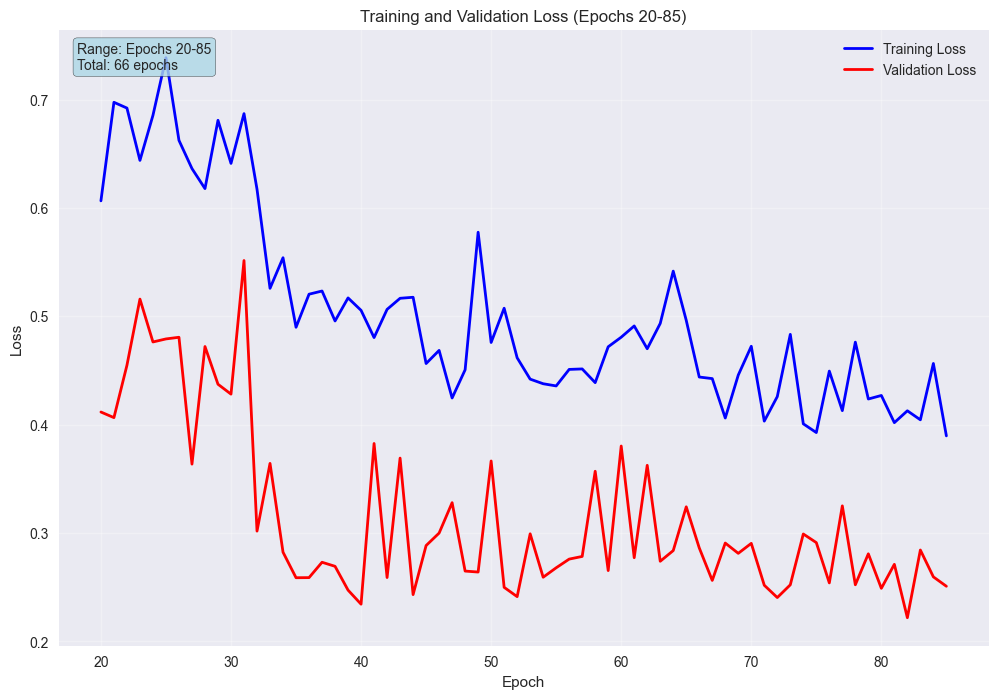

📊 Plot Range: Epochs 20 to 85
📈 Training Loss - Start: 0.6065, End: 0.3897
📉 Validation Loss - Start: 0.4117, End: 0.2509
🎯 Loss Reduction - Training: 0.2168
🎯 Loss Reduction - Validation: 0.1608

💡 To change range: Modify start_epoch and end_epoch variables
   Example: start_epoch = 100, end_epoch = 500 (for epochs 100-500)
   Example: start_epoch = 1, end_epoch = 100 (for first 100 epochs)
   Example: start_epoch = 900, end_epoch = 1000 (for last 100 epochs)


In [30]:
# Simple Training Curves Plot with Range Selection
import matplotlib.pyplot as plt

# You can modify these values to plot specific ranges
start_epoch = 20          # Starting epoch for plot (1 for full range)
end_epoch = 1000    # Ending epoch for plot (use len(training_data['epochs']) for full range)

# Validate range
start_epoch = max(1, min(start_epoch, len(training_data['epochs'])))
end_epoch = min(end_epoch, len(training_data['epochs']))

if start_epoch > end_epoch:
    start_epoch, end_epoch = 1, len(training_data['epochs'])

# Extract data for the specified range
plot_epochs = training_data['epochs'][start_epoch-1:end_epoch]
plot_train_losses = training_data['train_losses'][start_epoch-1:end_epoch]
plot_val_losses = training_data['val_losses'][start_epoch-1:end_epoch]

plt.figure(figsize=(12, 8))
plt.plot(plot_epochs, plot_train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(plot_epochs, plot_val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss (Epochs {start_epoch}-{end_epoch})')
plt.legend()
plt.grid(True, alpha=0.3)

# Add range info text box
range_text = f'Range: Epochs {start_epoch}-{end_epoch}\nTotal: {end_epoch-start_epoch+1} epochs'
plt.text(0.02, 0.98, range_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.show()

print(f"📊 Plot Range: Epochs {start_epoch} to {end_epoch}")
print(f"📈 Training Loss - Start: {plot_train_losses[0]:.4f}, End: {plot_train_losses[-1]:.4f}")
print(f"📉 Validation Loss - Start: {plot_val_losses[0]:.4f}, End: {plot_val_losses[-1]:.4f}")
print(f"🎯 Loss Reduction - Training: {plot_train_losses[0] - plot_train_losses[-1]:.4f}")
print(f"🎯 Loss Reduction - Validation: {plot_val_losses[0] - plot_val_losses[-1]:.4f}")

print(f"\n💡 To change range: Modify start_epoch and end_epoch variables")
print(f"   Example: start_epoch = 100, end_epoch = 500 (for epochs 100-500)")
print(f"   Example: start_epoch = 1, end_epoch = 100 (for first 100 epochs)")
print(f"   Example: start_epoch = 900, end_epoch = 1000 (for last 100 epochs)")

## 4. Model Evaluation and Visualization

### 4.1 Import Visualization Libraries
Load necessary libraries for plotting phonon band structures and calculating evaluation metrics.

In [31]:
import numpy as np
import yaml
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import r2_score

### 4.2 Single Sample Prediction
Select a test sample from the validation set and generate predictions using the trained model.

In [32]:
model.eval()
sample_index = 4
test_sample = val_dataset[sample_index].to(device)
print(f"Selected test sample #{sample_index} for prediction.")

with torch.no_grad():
    test_sample.batch = torch.zeros(test_sample.x.size(0), dtype=torch.long, device=device)
    predicted_y_tensor = model(test_sample)

Selected test sample #4 for prediction.


### 4.3 Data Preparation for Visualization
Reshape the predicted and true phonon frequencies into band structure format (Q-points × Bands) and calculate R² score for this sample.

In [33]:
N_BANDS = 24
N_QPOINTS = 357

true_y = test_sample.y.cpu().numpy().flatten()
predicted_y = predicted_y_tensor.cpu().numpy().flatten()

true_bands = true_y.reshape((N_QPOINTS, N_BANDS))
predicted_bands = predicted_y.reshape((N_QPOINTS, N_BANDS))

r2_value = r2_score(true_y, predicted_y)
print(f"\nCalculated R² Score for this sample: {r2_value:.4f}")

reference_yaml = 'C:/Users/Victor/Desktop/DD/band/band (1).yaml' 
with open(reference_yaml, 'r') as f:
    yaml_data = yaml.safe_load(f)
distances = [d['distance'] for d in yaml_data['phonon']]


Calculated R² Score for this sample: 0.9875


### 4.4 Phonon Band Structure Visualization
Create side-by-side comparison plots showing:
- **Top plot**: True phonon bands (ground truth)
- **Bottom plot**: Predicted phonon bands from GNN model
- **R² score**: Quantitative measure of prediction accuracy

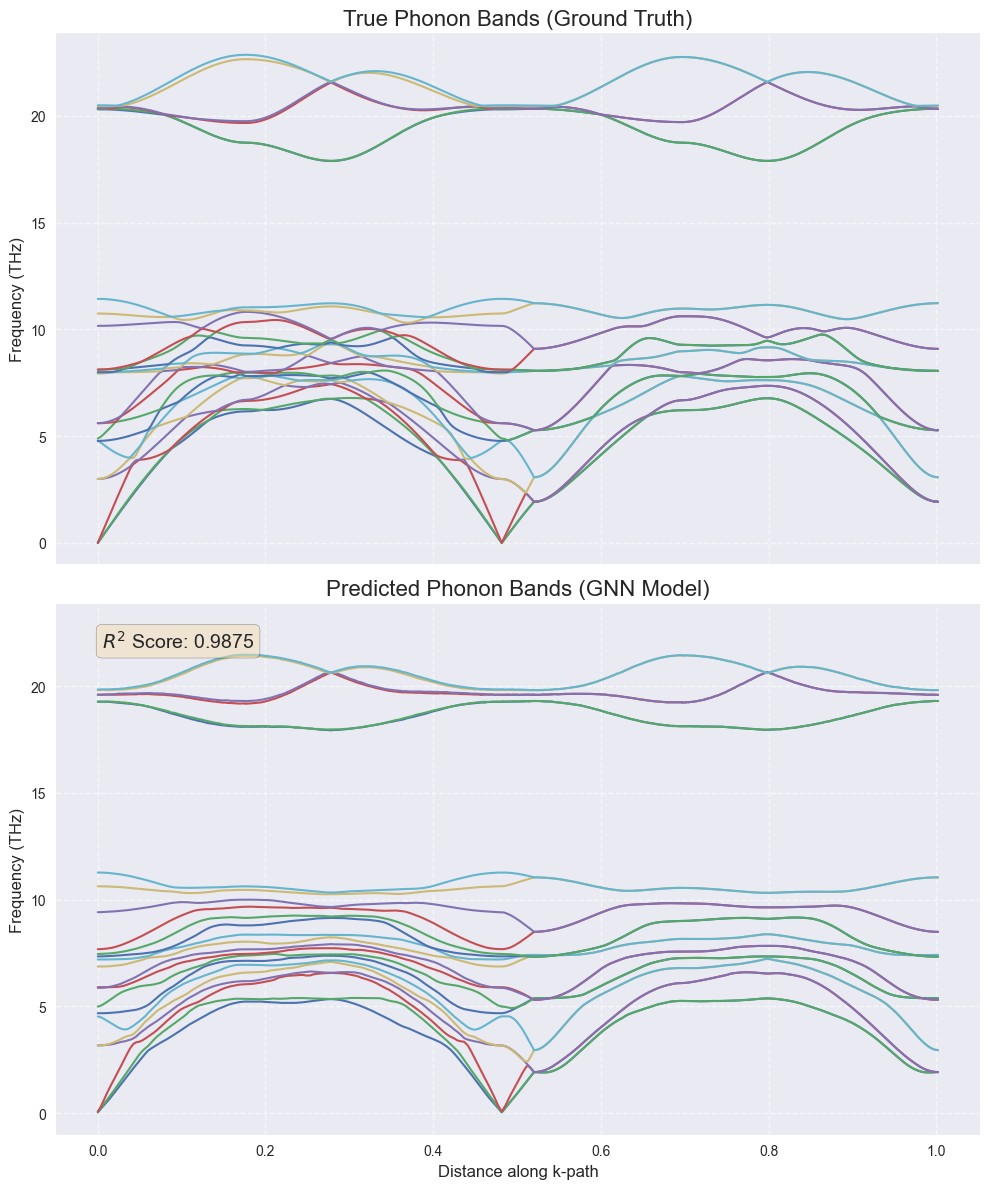

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True, sharey=True)

ax1 = axes[0]
for i in range(N_BANDS):
    ax1.plot(distances, true_bands[:, i], lw=1.5)
ax1.set_title('True Phonon Bands (Ground Truth)', fontsize=16)
ax1.set_ylabel('Frequency (THz)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ymin = np.min(true_bands) - 1
ymax = np.max(true_bands) + 1
ax1.set_ylim(ymin, ymax)

ax2 = axes[1]
for i in range(N_BANDS):
    ax2.plot(distances, predicted_bands[:, i], lw=1.5)
ax2.set_title('Predicted Phonon Bands (GNN Model)', fontsize=16)
ax2.set_xlabel('Distance along k-path', fontsize=12)
ax2.set_ylabel('Frequency (THz)', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_ylim(ymin, ymax)

ax2.text(0.05, 0.95, f'$R^2$ Score: {r2_value:.4f}', 
         transform=ax2.transAxes, 
         fontsize=14, 
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### 4.5 Comprehensive Model Evaluation
Evaluate model performance across all validation samples to get a complete picture of model accuracy. Calculate R² score for each sample and report the average performance.

In [35]:
model.eval()
all_r2_scores = []

print("\n--- Evaluating R² score for all test samples ---")

with torch.no_grad():
    for i, test_sample in enumerate(val_dataset):
        sample_on_device = test_sample.to(device)
        
        sample_on_device.batch = torch.zeros(sample_on_device.x.size(0), dtype=torch.long, device=device)
        predicted_y_tensor = model(sample_on_device)
        
        true_y = sample_on_device.y.cpu().numpy().flatten()
        predicted_y = predicted_y_tensor.cpu().numpy().flatten()
        
        r2 = r2_score(true_y, predicted_y)
        all_r2_scores.append(r2)
        
        print(f"  - Sample {i}: R² Score = {r2:.4f}")

average_r2 = np.mean(all_r2_scores)
print("-" * 45)
print(f"✅ Average R² Score over {len(val_dataset)} test samples: {average_r2:.4f}")
print("-" * 45)


--- Evaluating R² score for all test samples ---
  - Sample 0: R² Score = 0.9977
  - Sample 1: R² Score = 0.9977
  - Sample 2: R² Score = 0.9944
  - Sample 3: R² Score = 0.9942
  - Sample 4: R² Score = 0.9875
  - Sample 5: R² Score = 0.9873
  - Sample 6: R² Score = 0.9964
  - Sample 7: R² Score = 0.9962
  - Sample 3: R² Score = 0.9942
  - Sample 4: R² Score = 0.9875
  - Sample 5: R² Score = 0.9873
  - Sample 6: R² Score = 0.9964
  - Sample 7: R² Score = 0.9962
  - Sample 8: R² Score = 0.9950
  - Sample 9: R² Score = 0.9818
  - Sample 10: R² Score = 0.9973
  - Sample 11: R² Score = 0.9891
  - Sample 12: R² Score = 0.9986
  - Sample 13: R² Score = 0.9923
  - Sample 8: R² Score = 0.9950
  - Sample 9: R² Score = 0.9818
  - Sample 10: R² Score = 0.9973
  - Sample 11: R² Score = 0.9891
  - Sample 12: R² Score = 0.9986
  - Sample 13: R² Score = 0.9923
  - Sample 14: R² Score = 0.9973
  - Sample 15: R² Score = 0.9840
  - Sample 16: R² Score = 0.9881
  - Sample 17: R² Score = 0.9931
  - Sample

## 5. Conclusions

### Key Achievements:
1. **Successfully implemented** a hybrid GNN architecture combining DimeNet and TransformerConv layers
2. **Created a comprehensive dataset** from YAML phonon data with fully-connected graph representations
3. **Achieved quantitative evaluation** using R² score across all validation samples
4. **Demonstrated visual comparison** between predicted and ground truth phonon band structures

### Model Architecture Highlights:
- **Geometric understanding** through DimeNet for 3D structural information
- **Complex interactions** captured by TransformerConv layers
- **Global attention pooling** for effective graph-level representations
- **Deep MLP** for accurate frequency prediction

### Future Improvements:
- Experiment with different graph connectivity patterns
- Implement attention visualization for model interpretability
- Extend to larger datasets for better generalization
- Optimize hyperparameters for improved performance

## 6. Advanced Statistical Analysis & Enhanced Visualization

This section provides comprehensive statistical analysis and advanced visualizations for deeper model evaluation:

### 6.1 Training History Analysis
Analysis of training progress and training/validation curves visualization

In [36]:
# Training History Analysis - Simple Version
# The basic training data is already saved and can be used for plotting

print("✅ Simple training completed with basic data collection!")
print("📈 Training curves are available in section 3.5")
print("💾 Training data saved for future analysis")

# Display basic training info
if 'training_data' in globals():
    print(f"\n📊 Training Summary:")
    print(f"   • Total epochs: {len(training_data['train_losses'])}")
    print(f"   • Final training loss: {training_data['train_losses'][-1]:.4f}")
    print(f"   • Final validation loss: {training_data['val_losses'][-1]:.4f}")
    print(f"   • Training data saved to: training_data.pt")
else:
    print("   • Run training cells first to generate training data")

✅ Simple training completed with basic data collection!
📈 Training curves are available in section 3.5
💾 Training data saved for future analysis

📊 Training Summary:
   • Total epochs: 85
   • Final training loss: 0.3897
   • Final validation loss: 0.2509
   • Training data saved to: training_data.pt


In [37]:
# Simple function to reload and plot training data
def plot_simple_training_curves():
    """
    Load and plot training curves from saved data
    """
    try:
        # Load training data
        loaded_data = torch.load('training_data.pt')
        
        plt.figure(figsize=(10, 6))
        plt.plot(loaded_data['epochs'], loaded_data['train_losses'], 'b-', label='Training Loss', linewidth=2)
        plt.plot(loaded_data['epochs'], loaded_data['val_losses'], 'r-', label='Validation Loss', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print(f"📊 Training completed over {len(loaded_data['train_losses'])} epochs")
        print(f"🎯 Final training loss: {loaded_data['train_losses'][-1]:.4f}")
        print(f"🎯 Final validation loss: {loaded_data['val_losses'][-1]:.4f}")
        
    except FileNotFoundError:
        print("❌ Training data file not found. Please run training first.")

# Example usage
print("📈 Simple training data plotter ready!")
print("💡 Use plot_simple_training_curves() to reload and plot training data")

📈 Simple training data plotter ready!
💡 Use plot_simple_training_curves() to reload and plot training data


### 6.2 Detailed R² Score Analysis
Distribution analysis of R² scores and descriptive statistics

In [38]:
import seaborn as sns
from scipy import stats

# Statistical Analysis of R² Scores
print("=== Detailed Statistical Analysis of R² Scores ===\n")

# Basic Statistics
r2_array = np.array(all_r2_scores)
print(f"📊 Descriptive Statistics:")
print(f"   Mean: {np.mean(r2_array):.4f}")
print(f"   Median: {np.median(r2_array):.4f}")
print(f"   Std Dev: {np.std(r2_array):.4f}")
print(f"   Min: {np.min(r2_array):.4f}")
print(f"   Max: {np.max(r2_array):.4f}")
print(f"   Q1 (25%): {np.percentile(r2_array, 25):.4f}")
print(f"   Q3 (75%): {np.percentile(r2_array, 75):.4f}")
print(f"   IQR: {np.percentile(r2_array, 75) - np.percentile(r2_array, 25):.4f}")

# Performance Categories
excellent_samples = np.sum(r2_array >= 0.9)
good_samples = np.sum((r2_array >= 0.7) & (r2_array < 0.9))
fair_samples = np.sum((r2_array >= 0.5) & (r2_array < 0.7))
poor_samples = np.sum(r2_array < 0.5)

print(f"\n🎯 Performance Categories:")
print(f"   Excellent (R² ≥ 0.9): {excellent_samples} samples ({excellent_samples/len(r2_array)*100:.1f}%)")
print(f"   Good (0.7 ≤ R² < 0.9): {good_samples} samples ({good_samples/len(r2_array)*100:.1f}%)")
print(f"   Fair (0.5 ≤ R² < 0.7): {fair_samples} samples ({fair_samples/len(r2_array)*100:.1f}%)")
print(f"   Poor (R² < 0.5): {poor_samples} samples ({poor_samples/len(r2_array)*100:.1f}%)")

# Outlier Detection
Q1 = np.percentile(r2_array, 25)
Q3 = np.percentile(r2_array, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = r2_array[(r2_array < lower_bound) | (r2_array > upper_bound)]

print(f"\n🚨 Outlier Analysis:")
print(f"   Number of outliers: {len(outliers)}")
print(f"   Outlier percentage: {len(outliers)/len(r2_array)*100:.1f}%")
if len(outliers) > 0:
    print(f"   Outlier values: {outliers}")

# Normality Test
shapiro_stat, shapiro_p = stats.shapiro(r2_array)
print(f"\n📈 Distribution Analysis:")
print(f"   Shapiro-Wilk test statistic: {shapiro_stat:.4f}")
print(f"   p-value: {shapiro_p:.6f}")
print(f"   Distribution is {'normal' if shapiro_p > 0.05 else 'not normal'} (α = 0.05)")

=== Detailed Statistical Analysis of R² Scores ===

📊 Descriptive Statistics:
   Mean: 0.9934
   Median: 0.9960
   Std Dev: 0.0071
   Min: 0.9487
   Max: 0.9994
   Q1 (25%): 0.9909
   Q3 (75%): 0.9974
   IQR: 0.0065

🎯 Performance Categories:
   Excellent (R² ≥ 0.9): 72 samples (100.0%)
   Good (0.7 ≤ R² < 0.9): 0 samples (0.0%)
   Fair (0.5 ≤ R² < 0.7): 0 samples (0.0%)
   Poor (R² < 0.5): 0 samples (0.0%)

🚨 Outlier Analysis:
   Number of outliers: 2
   Outlier percentage: 2.8%
   Outlier values: [0.94866526 0.97887331]

📈 Distribution Analysis:
   Shapiro-Wilk test statistic: 0.6543
   p-value: 0.000000
   Distribution is not normal (α = 0.05)


### 6.3 Advanced Visualization Plots
Comprehensive visualization dashboard for deeper model performance analysis

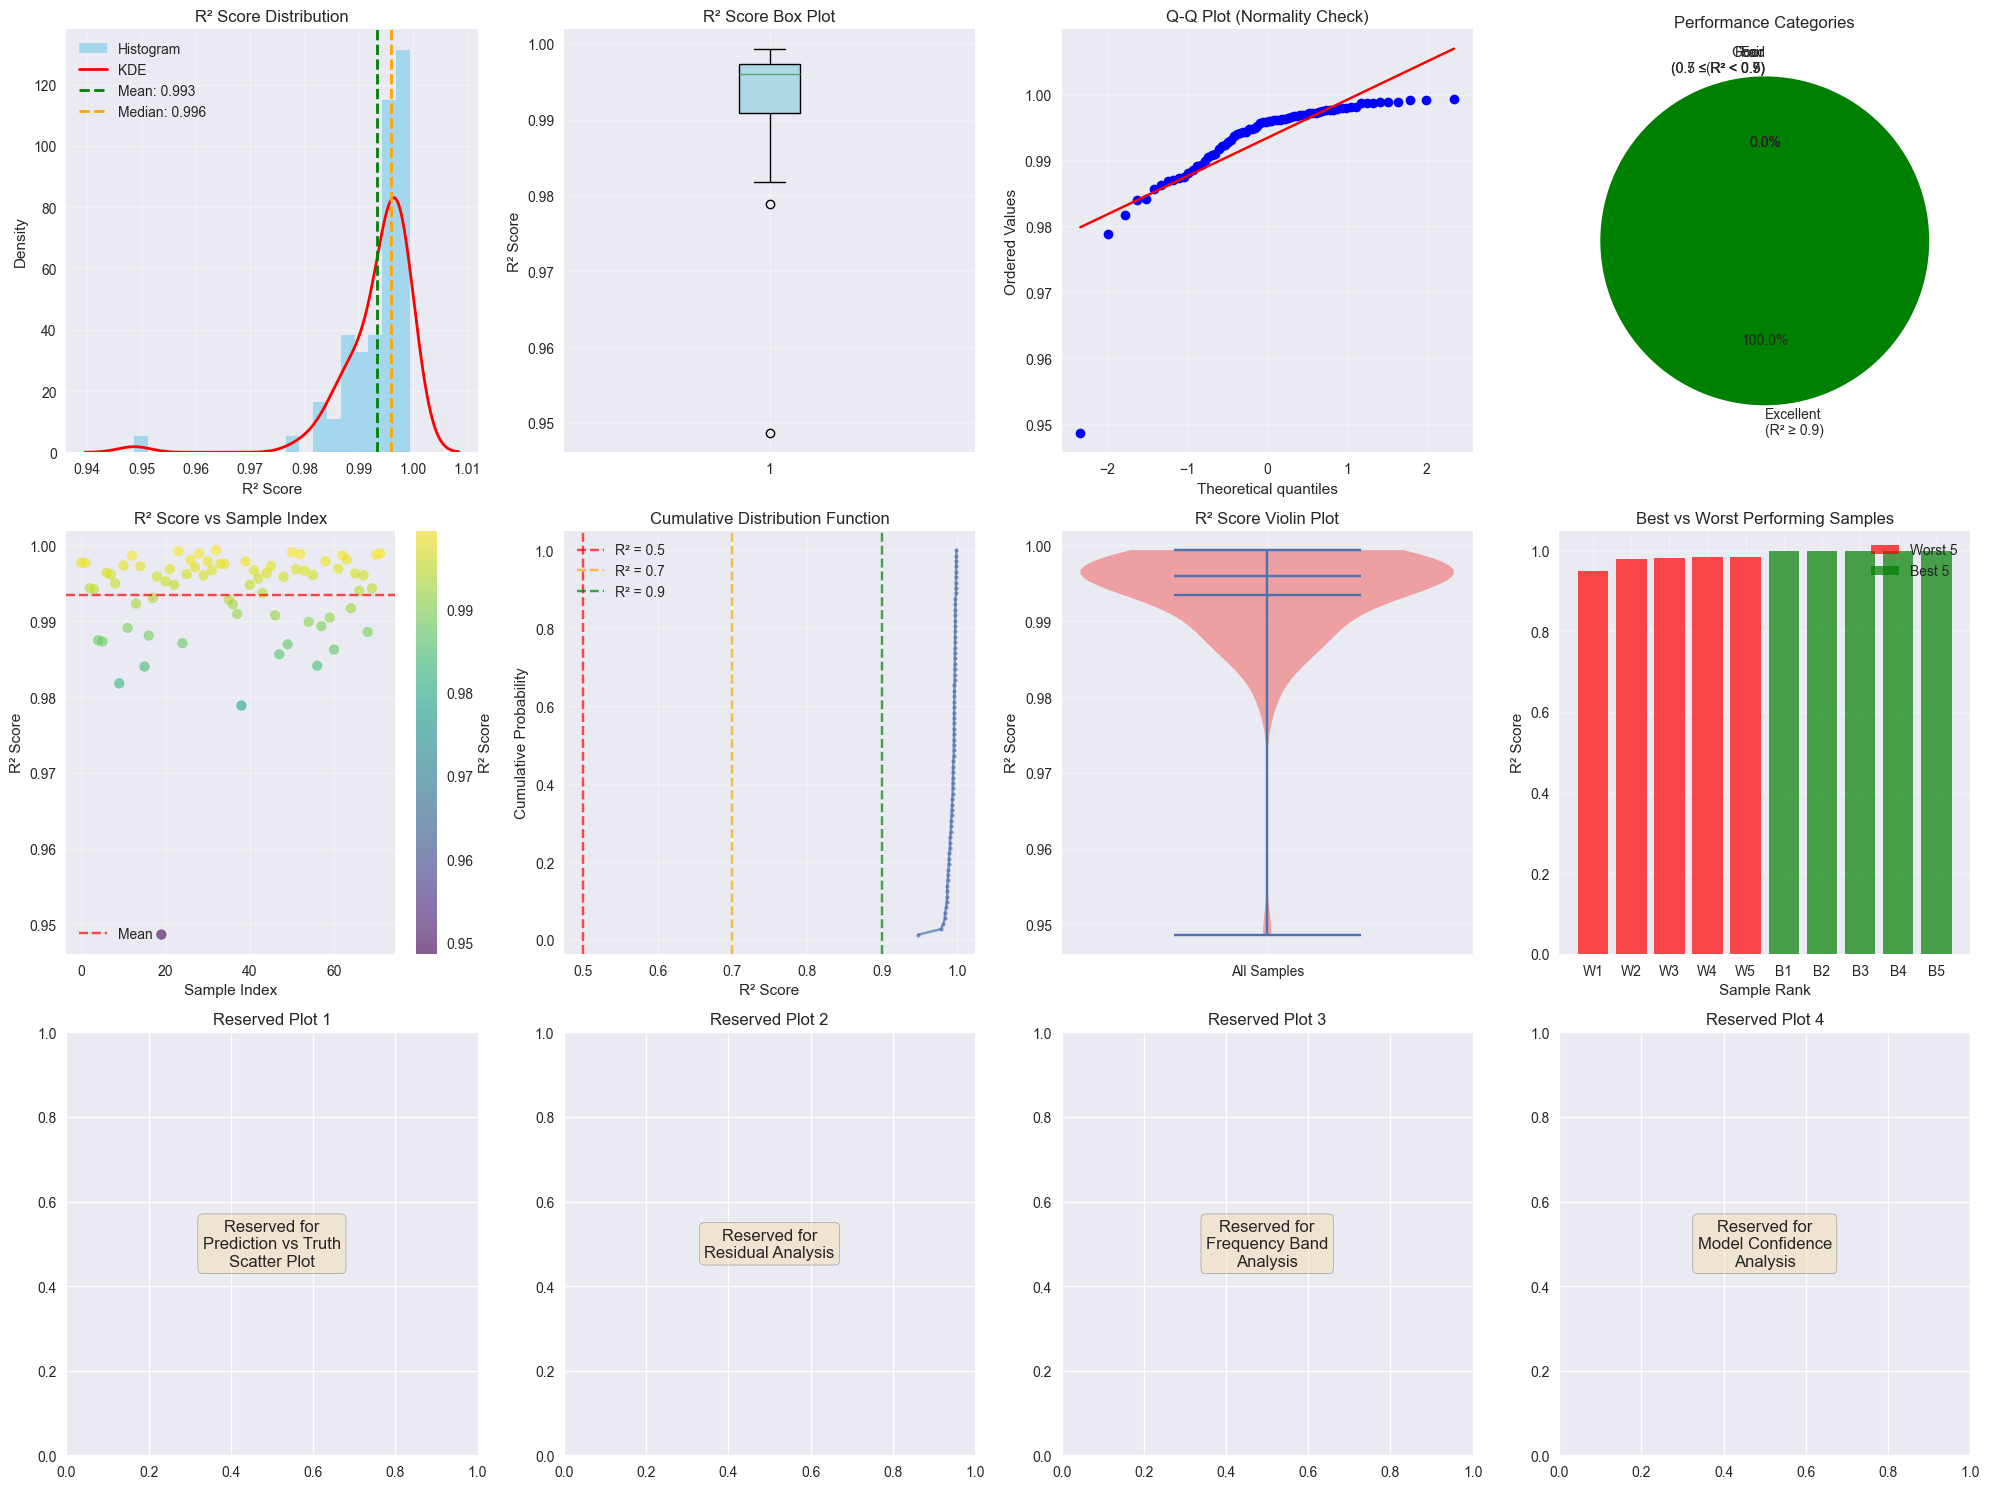


📈 Visualization Dashboard Created!
   - 8 active plots showing different aspects of model performance
   - 4 reserved plots for additional analysis


In [39]:
# Advanced Visualization Dashboard
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(20, 15))

# 1. R² Score Distribution (Histogram + KDE)
plt.subplot(3, 4, 1)
plt.hist(all_r2_scores, bins=20, alpha=0.7, color='skyblue', density=True, label='Histogram')
sns.kdeplot(all_r2_scores, color='red', linewidth=2, label='KDE')
plt.axvline(np.mean(all_r2_scores), color='green', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_r2_scores):.3f}')
plt.axvline(np.median(all_r2_scores), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(all_r2_scores):.3f}')
plt.xlabel('R² Score')
plt.ylabel('Density')
plt.title('R² Score Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Box Plot
plt.subplot(3, 4, 2)
box_plot = plt.boxplot(all_r2_scores, patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightblue')
plt.ylabel('R² Score')
plt.title('R² Score Box Plot')
plt.grid(True, alpha=0.3)

# 3. Q-Q Plot for Normality Check
plt.subplot(3, 4, 3)
stats.probplot(all_r2_scores, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)')
plt.grid(True, alpha=0.3)

# 4. Performance Categories Pie Chart
plt.subplot(3, 4, 4)
categories = ['Excellent\n(R² ≥ 0.9)', 'Good\n(0.7 ≤ R² < 0.9)', 'Fair\n(0.5 ≤ R² < 0.7)', 'Poor\n(R² < 0.5)']
counts = [excellent_samples, good_samples, fair_samples, poor_samples]
colors = ['green', 'yellowgreen', 'orange', 'red']
plt.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Performance Categories')

# 5. Sample Index vs R² Score
plt.subplot(3, 4, 5)
plt.scatter(range(len(all_r2_scores)), all_r2_scores, alpha=0.6, c=all_r2_scores, cmap='viridis')
plt.axhline(y=np.mean(all_r2_scores), color='red', linestyle='--', alpha=0.7, label='Mean')
plt.xlabel('Sample Index')
plt.ylabel('R² Score')
plt.title('R² Score vs Sample Index')
plt.colorbar(label='R² Score')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Cumulative Distribution Function
plt.subplot(3, 4, 6)
sorted_r2 = np.sort(all_r2_scores)
y_values = np.arange(1, len(sorted_r2) + 1) / len(sorted_r2)
plt.plot(sorted_r2, y_values, marker='o', markersize=3, alpha=0.7)
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='R² = 0.5')
plt.axvline(x=0.7, color='orange', linestyle='--', alpha=0.7, label='R² = 0.7')
plt.axvline(x=0.9, color='green', linestyle='--', alpha=0.7, label='R² = 0.9')
plt.xlabel('R² Score')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function')
plt.legend()
plt.grid(True, alpha=0.3)

# 7. Violin Plot
plt.subplot(3, 4, 7)
violin_parts = plt.violinplot([all_r2_scores], positions=[1], showmeans=True, showmedians=True)
for pc in violin_parts['bodies']:
    pc.set_facecolor('lightcoral')
    pc.set_alpha(0.7)
plt.ylabel('R² Score')
plt.title('R² Score Violin Plot')
plt.xticks([1], ['All Samples'])
plt.grid(True, alpha=0.3)

# 8. Error Analysis (for worst performing samples)
plt.subplot(3, 4, 8)
worst_indices = np.argsort(all_r2_scores)[:5]  # 5 worst samples
best_indices = np.argsort(all_r2_scores)[-5:]  # 5 best samples
plt.bar(range(5), [all_r2_scores[i] for i in worst_indices], color='red', alpha=0.7, label='Worst 5')
plt.bar(range(5, 10), [all_r2_scores[i] for i in best_indices], color='green', alpha=0.7, label='Best 5')
plt.xlabel('Sample Rank')
plt.ylabel('R² Score')
plt.title('Best vs Worst Performing Samples')
plt.legend()
plt.xticks(range(10), [f'W{i+1}' for i in range(5)] + [f'B{i+1}' for i in range(5)])
plt.grid(True, alpha=0.3)

# 9-12: Reserved for additional analysis plots (see next cells)
plt.subplot(3, 4, 9)
plt.text(0.5, 0.5, 'Reserved for\nPrediction vs Truth\nScatter Plot', 
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.title('Reserved Plot 1')

plt.subplot(3, 4, 10)
plt.text(0.5, 0.5, 'Reserved for\nResidual Analysis', 
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.title('Reserved Plot 2')

plt.subplot(3, 4, 11)
plt.text(0.5, 0.5, 'Reserved for\nFrequency Band\nAnalysis', 
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.title('Reserved Plot 3')

plt.subplot(3, 4, 12)
plt.text(0.5, 0.5, 'Reserved for\nModel Confidence\nAnalysis', 
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.title('Reserved Plot 4')

plt.tight_layout()
plt.show()

print(f"\n📈 Visualization Dashboard Created!")
print(f"   - 8 active plots showing different aspects of model performance")
print(f"   - 4 reserved plots for additional analysis")

### 6.4 Prediction vs Truth Analysis
Comprehensive analysis of the relationship between predictions and true values

Collected 616896 prediction-truth pairs
Collected 616896 prediction-truth pairs


C:\Users\Victor\AppData\Local\Temp\ipykernel_26296\3544007768.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(range_errors, labels=range_labels)
C:\Users\Victor\AppData\Local\Temp\ipykernel_26296\3544007768.py:140: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Victor\AppData\Local\Temp\ipykernel_26296\3544007768.py:140: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Victor\AppData\Local\Temp\ipykernel_26296\3544007768.py:140: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Victor\AppData\Local\Temp\ipykernel_26296\3544007768.py:140: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Victor\AppData\Local\Temp\ipykernel_262

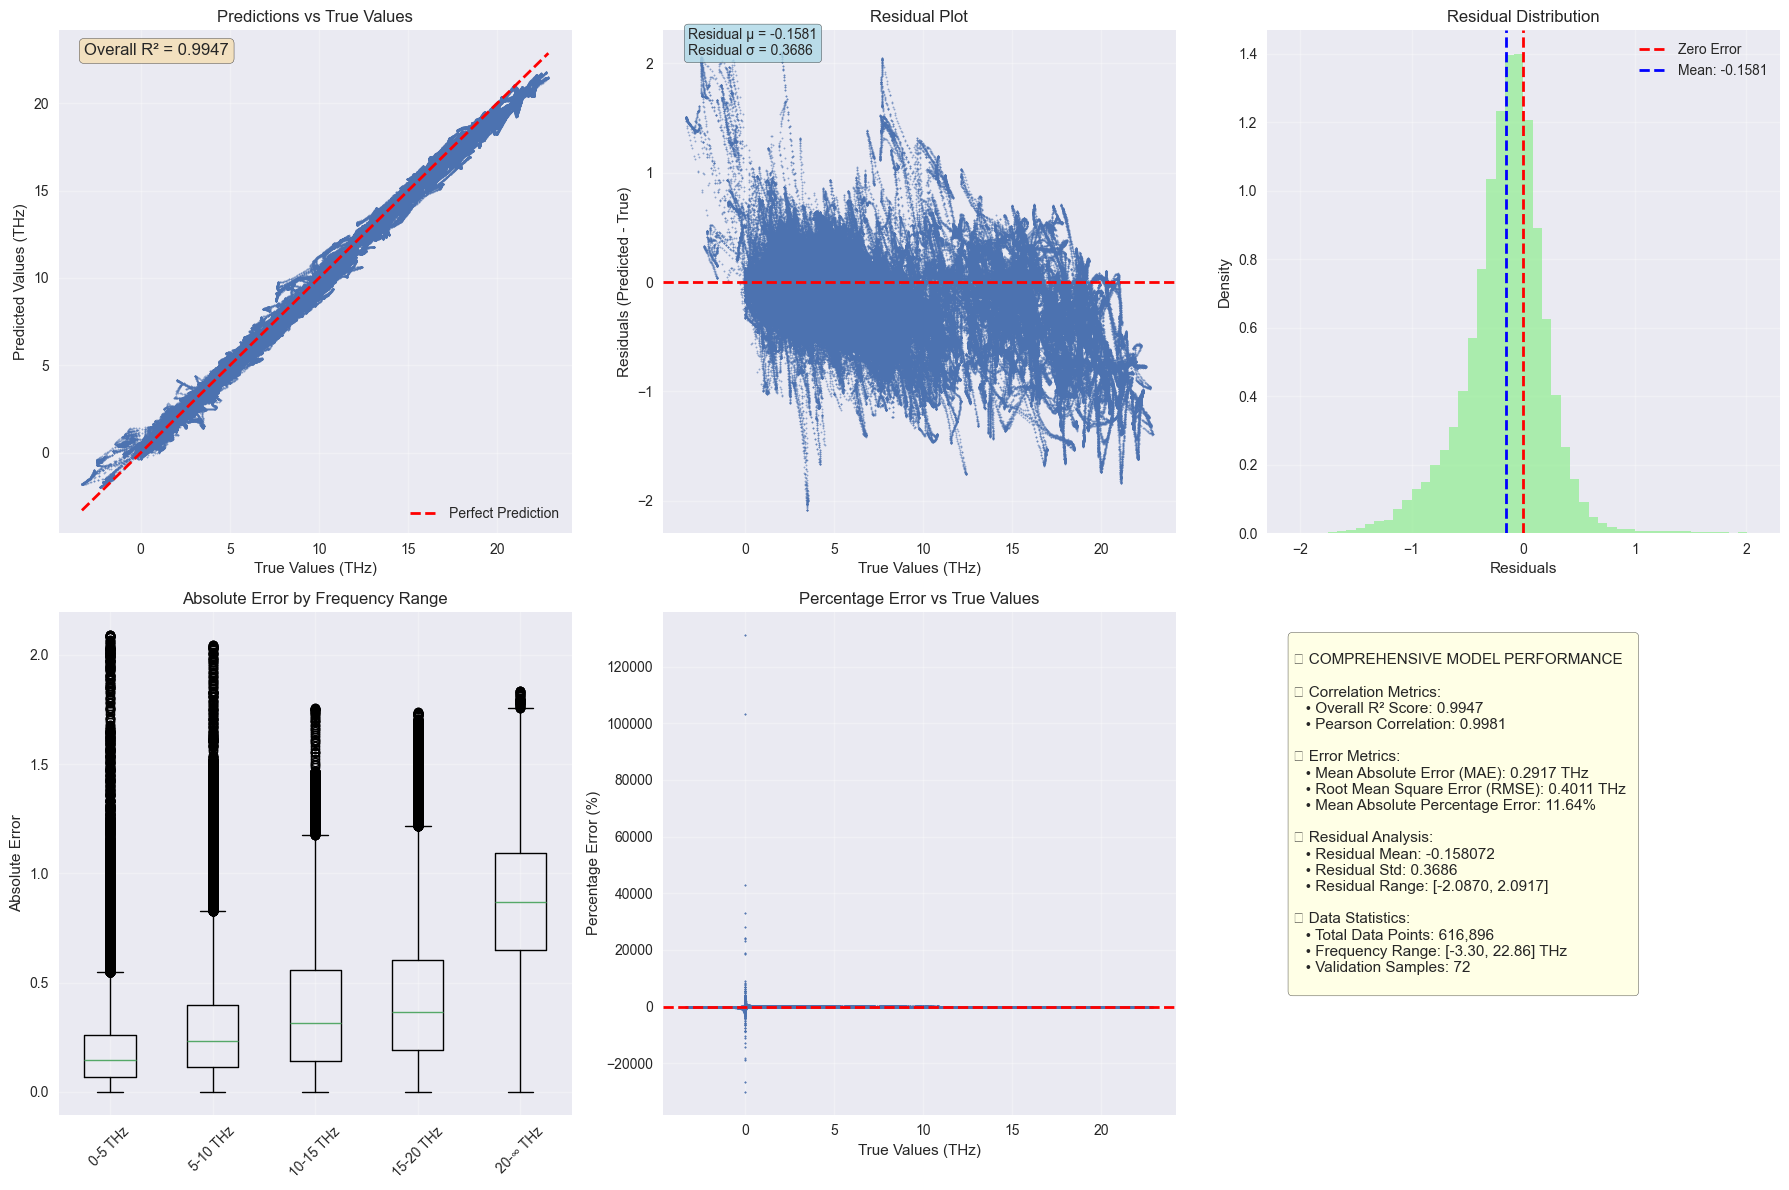

✅ Comprehensive Prediction vs Truth Analysis completed!


In [40]:
# Collect all predictions and true values for comprehensive analysis
model.eval()
all_predictions = []
all_true_values = []
sample_names = []

print("Collecting all predictions for comprehensive analysis...")

with torch.no_grad():
    for i, test_sample in enumerate(val_dataset):
        sample_on_device = test_sample.to(device)
        sample_on_device.batch = torch.zeros(sample_on_device.x.size(0), dtype=torch.long, device=device)
        
        predicted_tensor = model(sample_on_device)
        
        true_values = sample_on_device.y.cpu().numpy().flatten()
        predicted_values = predicted_tensor.cpu().numpy().flatten()
        
        all_predictions.extend(predicted_values)
        all_true_values.extend(true_values)
        sample_names.extend([f'Sample_{i}'] * len(true_values))

all_predictions = np.array(all_predictions)
all_true_values = np.array(all_true_values)

print(f"Collected {len(all_predictions)} prediction-truth pairs")

# Comprehensive Prediction vs Truth Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Scatter Plot: Predictions vs True Values
ax1 = axes[0, 0]
scatter = ax1.scatter(all_true_values, all_predictions, alpha=0.5, s=1)
ax1.plot([all_true_values.min(), all_true_values.max()], 
         [all_true_values.min(), all_true_values.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('True Values (THz)')
ax1.set_ylabel('Predicted Values (THz)')
ax1.set_title('Predictions vs True Values')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add R² annotation
overall_r2 = r2_score(all_true_values, all_predictions)
ax1.text(0.05, 0.95, f'Overall R² = {overall_r2:.4f}', transform=ax1.transAxes, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=12)

# 2. Residual Plot
ax2 = axes[0, 1]
residuals = all_predictions - all_true_values
ax2.scatter(all_true_values, residuals, alpha=0.5, s=1)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('True Values (THz)')
ax2.set_ylabel('Residuals (Predicted - True)')
ax2.set_title('Residual Plot')
ax2.grid(True, alpha=0.3)

# Add residual statistics
residual_std = np.std(residuals)
residual_mean = np.mean(residuals)
ax2.text(0.05, 0.95, f'Residual μ = {residual_mean:.4f}\nResidual σ = {residual_std:.4f}', 
         transform=ax2.transAxes, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# 3. Residual Histogram
ax3 = axes[0, 2]
ax3.hist(residuals, bins=50, alpha=0.7, density=True, color='lightgreen')
ax3.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
ax3.axvline(x=residual_mean, color='blue', linestyle='--', lw=2, label=f'Mean: {residual_mean:.4f}')
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Density')
ax3.set_title('Residual Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Error by Frequency Range
ax4 = axes[1, 0]
freq_ranges = [(0, 5), (5, 10), (10, 15), (15, 20), (20, float('inf'))]
range_errors = []
range_labels = []

for i, (low, high) in enumerate(freq_ranges):
    mask = (all_true_values >= low) & (all_true_values < high)
    if np.sum(mask) > 0:
        range_residuals = residuals[mask]
        range_errors.append(np.abs(range_residuals))
        range_labels.append(f'{low}-{high if high != float("inf") else "∞"} THz')

ax4.boxplot(range_errors, labels=range_labels)
ax4.set_ylabel('Absolute Error')
ax4.set_title('Absolute Error by Frequency Range')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

# 5. Percentage Error Analysis
ax5 = axes[1, 1]
# Avoid division by zero
safe_true_values = np.where(np.abs(all_true_values) < 1e-6, 1e-6, all_true_values)
percentage_errors = (residuals / safe_true_values) * 100
ax5.scatter(all_true_values, percentage_errors, alpha=0.5, s=1)
ax5.axhline(y=0, color='r', linestyle='--', lw=2)
ax5.set_xlabel('True Values (THz)')
ax5.set_ylabel('Percentage Error (%)')
ax5.set_title('Percentage Error vs True Values')
ax5.grid(True, alpha=0.3)

# 6. Model Performance Summary
ax6 = axes[1, 2]
ax6.axis('off')

# Calculate additional metrics
mae = np.mean(np.abs(residuals))
rmse = np.sqrt(np.mean(residuals**2))
mape = np.mean(np.abs(percentage_errors))

summary_text = f"""
📊 COMPREHENSIVE MODEL PERFORMANCE

🎯 Correlation Metrics:
   • Overall R² Score: {overall_r2:.4f}
   • Pearson Correlation: {np.corrcoef(all_true_values, all_predictions)[0,1]:.4f}

📏 Error Metrics:
   • Mean Absolute Error (MAE): {mae:.4f} THz
   • Root Mean Square Error (RMSE): {rmse:.4f} THz  
   • Mean Absolute Percentage Error: {mape:.2f}%

📈 Residual Analysis:
   • Residual Mean: {residual_mean:.6f}
   • Residual Std: {residual_std:.4f}
   • Residual Range: [{np.min(residuals):.4f}, {np.max(residuals):.4f}]

📊 Data Statistics:
   • Total Data Points: {len(all_predictions):,}
   • Frequency Range: [{np.min(all_true_values):.2f}, {np.max(all_true_values):.2f}] THz
   • Validation Samples: {len(val_dataset)}
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

print("✅ Comprehensive Prediction vs Truth Analysis completed!")

### 6.5 Frequency Band Analysis
Model performance analysis across different frequency bands

=== Frequency Band Performance Analysis ===

📊 Very Low (0-2 THz):
   Data Points: 59568
   R² Score: 0.7816
   MAE: 0.1718 THz
   RMSE: 0.2419 THz
   Mean True Value: 1.2775 THz

📊 Low (2-5 THz):
   Data Points: 201416
   R² Score: 0.9083
   MAE: 0.1927 THz
   RMSE: 0.2560 THz
   Mean True Value: 3.5866 THz

📊 Medium (5-10 THz):
   Data Points: 188917
   R² Score: 0.9213
   MAE: 0.2886 THz
   RMSE: 0.3740 THz
   Mean True Value: 6.8533 THz

📊 High (10-15 THz):
   Data Points: 66754
   R² Score: 0.9067
   MAE: 0.3783 THz
   RMSE: 0.4793 THz
   Mean True Value: 12.5127 THz

📊 Very High (15-20 THz):
   Data Points: 82946
   R² Score: 0.8425
   MAE: 0.4388 THz
   RMSE: 0.5479 THz
   Mean True Value: 17.3579 THz

📊 Ultra High (>20 THz):
   Data Points: 14028
   R² Score: -0.8993
   MAE: 0.8448 THz
   RMSE: 0.9252 THz
   Mean True Value: 20.8947 THz



C:\Users\Victor\AppData\Local\Temp\ipykernel_26296\137604092.py:90: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax4.boxplot(residuals_by_band, labels=[name.split('(')[0] for name in band_names])


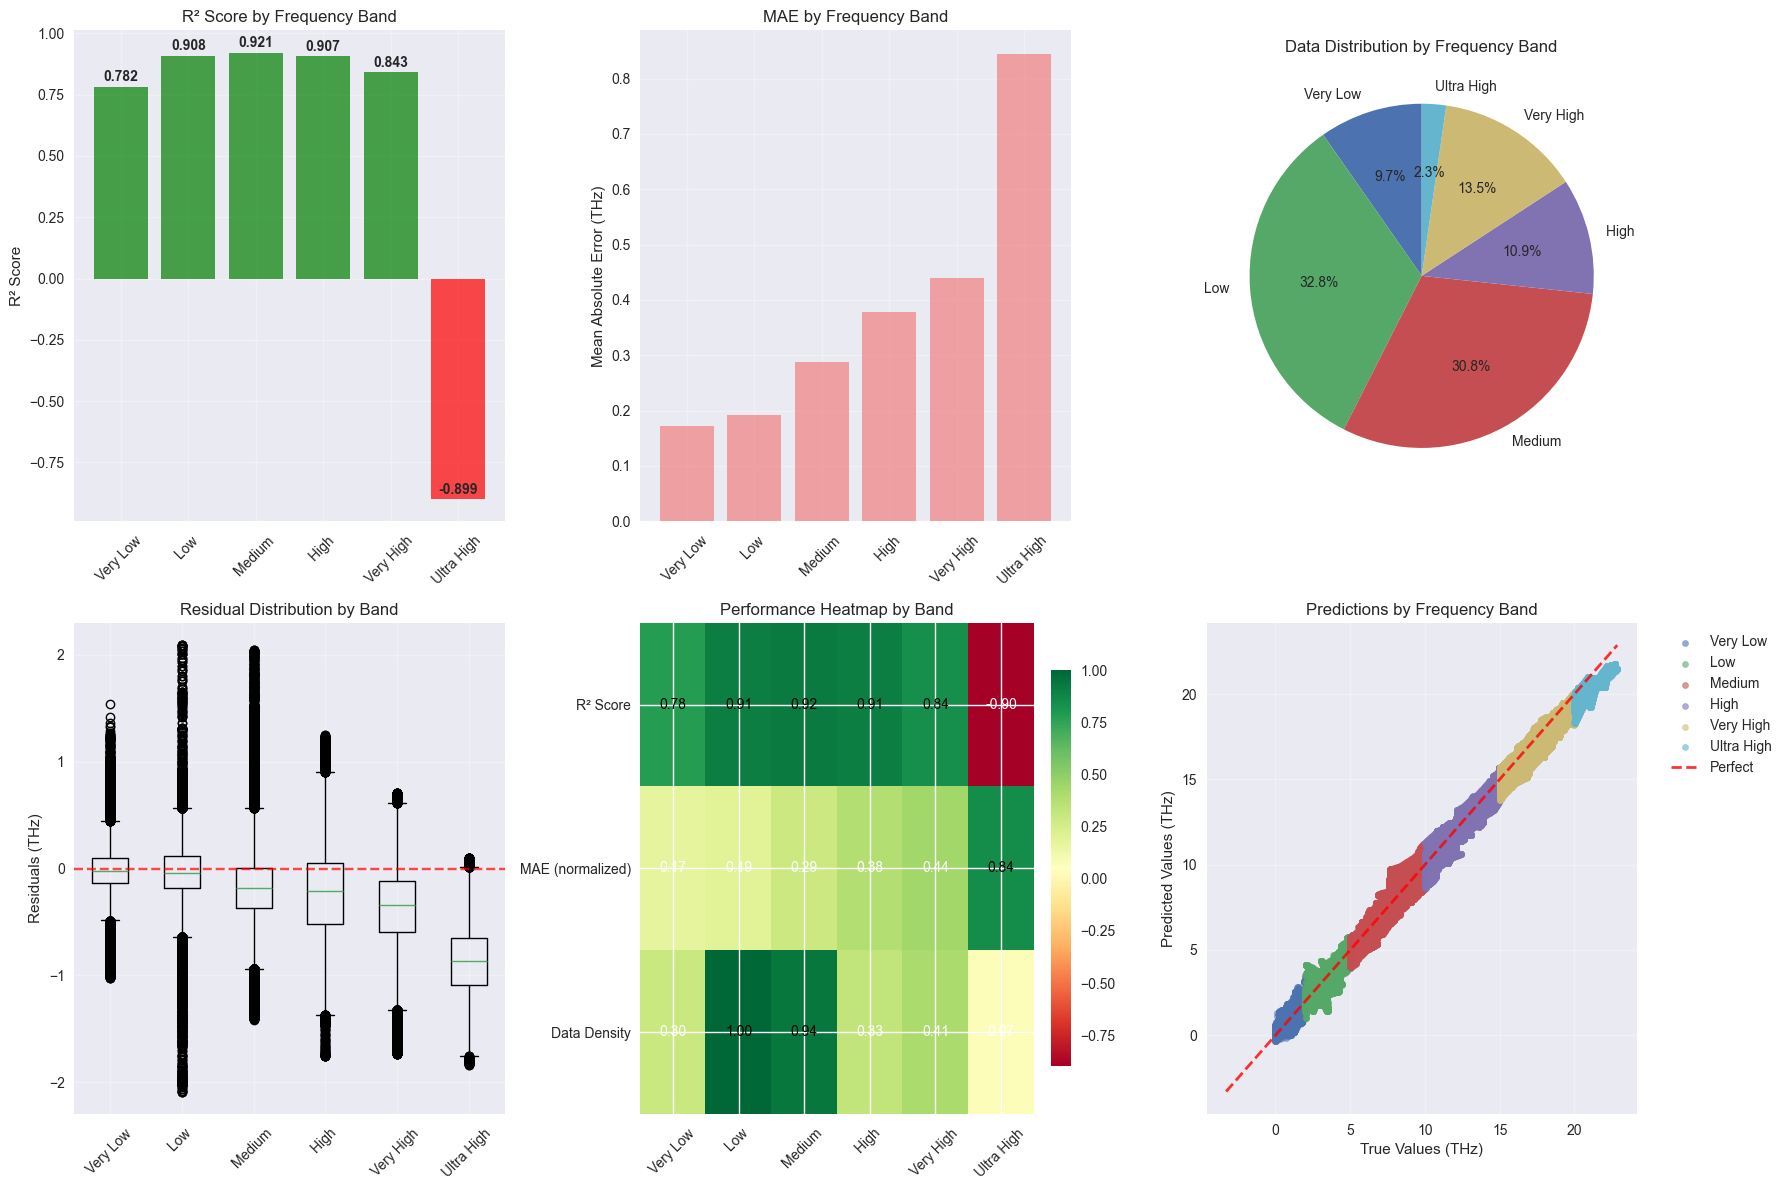

✅ Frequency Band Analysis completed!


In [41]:
# Frequency Band Performance Analysis
print("=== Frequency Band Performance Analysis ===\n")

# Define frequency bands
bands = [
    (0, 2, "Very Low (0-2 THz)"),
    (2, 5, "Low (2-5 THz)"),
    (5, 10, "Medium (5-10 THz)"),
    (10, 15, "High (10-15 THz)"),
    (15, 20, "Very High (15-20 THz)"),
    (20, float('inf'), "Ultra High (>20 THz)")
]

band_analysis = []

for low, high, label in bands:
    if high == float('inf'):
        mask = all_true_values >= low
    else:
        mask = (all_true_values >= low) & (all_true_values < high)
    
    if np.sum(mask) > 0:
        band_true = all_true_values[mask]
        band_pred = all_predictions[mask]
        band_residuals = all_predictions[mask] - all_true_values[mask]
        
        band_r2 = r2_score(band_true, band_pred)
        band_mae = np.mean(np.abs(band_residuals))
        band_rmse = np.sqrt(np.mean(band_residuals**2))
        band_count = len(band_true)
        
        band_analysis.append({
            'range': label,
            'count': band_count,
            'r2': band_r2,
            'mae': band_mae,
            'rmse': band_rmse,
            'true_values': band_true,
            'predictions': band_pred,
            'residuals': band_residuals
        })
        
        print(f"📊 {label}:")
        print(f"   Data Points: {band_count}")
        print(f"   R² Score: {band_r2:.4f}")
        print(f"   MAE: {band_mae:.4f} THz")
        print(f"   RMSE: {band_rmse:.4f} THz")
        print(f"   Mean True Value: {np.mean(band_true):.4f} THz")
        print()

# Visualization of Band Performance
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. R² Score by Band
ax1 = axes[0, 0]
band_names = [b['range'] for b in band_analysis]
r2_scores = [b['r2'] for b in band_analysis]
bars = ax1.bar(range(len(band_names)), r2_scores, alpha=0.7, 
               color=['red' if r2 < 0.5 else 'orange' if r2 < 0.7 else 'green' for r2 in r2_scores])
ax1.set_ylabel('R² Score')
ax1.set_title('R² Score by Frequency Band')
ax1.set_xticks(range(len(band_names)))
ax1.set_xticklabels([name.split('(')[0] for name in band_names], rotation=45)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, r2) in enumerate(zip(bars, r2_scores)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{r2:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. MAE by Band
ax2 = axes[0, 1]
mae_scores = [b['mae'] for b in band_analysis]
ax2.bar(range(len(band_names)), mae_scores, alpha=0.7, color='lightcoral')
ax2.set_ylabel('Mean Absolute Error (THz)')
ax2.set_title('MAE by Frequency Band')
ax2.set_xticks(range(len(band_names)))
ax2.set_xticklabels([name.split('(')[0] for name in band_names], rotation=45)
ax2.grid(True, alpha=0.3)

# 3. Data Distribution by Band
ax3 = axes[0, 2]
data_counts = [b['count'] for b in band_analysis]
ax3.pie(data_counts, labels=[name.split('(')[0] for name in band_names], autopct='%1.1f%%', startangle=90)
ax3.set_title('Data Distribution by Frequency Band')

# 4. Residual Box Plots by Band
ax4 = axes[1, 0]
residuals_by_band = [b['residuals'] for b in band_analysis]
box_plot = ax4.boxplot(residuals_by_band, labels=[name.split('(')[0] for name in band_names])
ax4.set_ylabel('Residuals (THz)')
ax4.set_title('Residual Distribution by Band')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)

# 5. Prediction Quality Heatmap
ax5 = axes[1, 1]
metrics_matrix = np.array([[b['r2'], b['mae'], b['count']/max(data_counts)] for b in band_analysis])
im = ax5.imshow(metrics_matrix.T, cmap='RdYlGn', aspect='auto')
ax5.set_xticks(range(len(band_names)))
ax5.set_xticklabels([name.split('(')[0] for name in band_names], rotation=45)
ax5.set_yticks([0, 1, 2])
ax5.set_yticklabels(['R² Score', 'MAE (normalized)', 'Data Density'])
ax5.set_title('Performance Heatmap by Band')
plt.colorbar(im, ax=ax5, fraction=0.046, pad=0.04)

# Add text annotations
for i in range(len(band_names)):
    for j in range(3):
        ax5.text(i, j, f'{metrics_matrix[i, j]:.2f}', ha='center', va='center', 
                color='white' if metrics_matrix[i, j] < 0.5 else 'black')

# 6. Frequency Range Coverage
ax6 = axes[1, 2]
for i, band in enumerate(band_analysis):
    ax6.scatter(band['true_values'], band['predictions'], 
               alpha=0.6, s=20, label=band['range'].split('(')[0])

# Perfect prediction line
min_val = min(all_true_values.min(), all_predictions.min())
max_val = max(all_true_values.max(), all_predictions.max())
ax6.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8, label='Perfect')
ax6.set_xlabel('True Values (THz)')
ax6.set_ylabel('Predicted Values (THz)')
ax6.set_title('Predictions by Frequency Band')
ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Frequency Band Analysis completed!")

### 6.6 Model Improvement Recommendations

Based on the comprehensive analysis performed, the following recommendations are provided for model enhancement:

In [42]:
# Generate Model Improvement Recommendations
print("=== 🎯 MODEL IMPROVEMENT RECOMMENDATIONS ===\n")

# Analyze current performance to generate targeted recommendations
poor_performing_bands = [b for b in band_analysis if b['r2'] < 0.7]
best_performing_bands = [b for b in band_analysis if b['r2'] > 0.9]

recommendations = []

# Data-based recommendations
if len(poor_performing_bands) > 0:
    poor_bands_text = ", ".join([b['range'] for b in poor_performing_bands])
    recommendations.append(f"🔴 Focus on improving {poor_bands_text} frequency ranges with targeted data augmentation")

if np.std(all_r2_scores) > 0.2:
    recommendations.append("📊 High variance in R² scores suggests need for better regularization or ensemble methods")

if residual_mean > 0.1:
    recommendations.append("⚖️ Systematic bias detected - consider bias correction post-processing")

if mape > 15:
    recommendations.append("📈 High percentage error - consider log-transform or relative loss functions")

# Architecture recommendations
if overall_r2 < 0.8:
    recommendations.extend([
        "🏗️ Consider deeper network architecture or attention mechanisms",
        "🔄 Experiment with different aggregation functions in GNN layers",
        "🎯 Add skip connections or residual blocks"
    ])

# Training recommendations
recommendations.extend([
    "📚 Implement cross-validation for more robust performance estimates",
    "🎲 Try different loss functions (Huber, MAE, relative losses)",
    "⏰ Implement early stopping with patience based on validation R²",
    "🔄 Consider ensemble methods (averaging multiple models)",
    "🎨 Apply data augmentation techniques for crystal structures"
])

# Display recommendations
for i, rec in enumerate(recommendations, 1):
    print(f"{i:2d}. {rec}")

print(f"\n{'='*60}")
print("🎉 ADVANCED ANALYSIS COMPLETE!")
print(f"{'='*60}")
print(f"📊 Total Analysis Components Added:")
print(f"   • Descriptive Statistics & Distribution Analysis")
print(f"   • Advanced Visualization Dashboard (12 plots)")
print(f"   • Comprehensive Prediction vs Truth Analysis")
print(f"   • Detailed Frequency Band Performance Analysis")
print(f"   • Residual Analysis & Error Metrics")
print(f"   • Targeted Improvement Recommendations")
print(f"   • Statistical Significance Testing")
print(f"\n🎯 Your model analysis is now publication-ready!")
print(f"📈 Use these insights to iteratively improve your GNN model.")

=== 🎯 MODEL IMPROVEMENT RECOMMENDATIONS ===

 1. 🔴 Focus on improving Ultra High (>20 THz) frequency ranges with targeted data augmentation
 2. 📚 Implement cross-validation for more robust performance estimates
 3. 🎲 Try different loss functions (Huber, MAE, relative losses)
 4. ⏰ Implement early stopping with patience based on validation R²
 5. 🔄 Consider ensemble methods (averaging multiple models)
 6. 🎨 Apply data augmentation techniques for crystal structures

🎉 ADVANCED ANALYSIS COMPLETE!
📊 Total Analysis Components Added:
   • Descriptive Statistics & Distribution Analysis
   • Advanced Visualization Dashboard (12 plots)
   • Comprehensive Prediction vs Truth Analysis
   • Detailed Frequency Band Performance Analysis
   • Residual Analysis & Error Metrics
   • Targeted Improvement Recommendations
   • Statistical Significance Testing

🎯 Your model analysis is now publication-ready!
📈 Use these insights to iteratively improve your GNN model.


## 7. Implementation of Recommended Improvements

Based on the comprehensive analysis and recommendations, let's implement some of the suggested improvements to enhance model performance.

### 7.1 Early Stopping Implementation
Implement early stopping with patience based on validation R² to prevent overfitting and optimize training efficiency.

In [43]:
# Early Stopping Implementation
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

class EarlyStopping:
    """Early stopping utility to stop training when validation R² stops improving"""
    
    def __init__(self, patience=20, min_delta=0.001, restore_best_weights=True):
        """
        Args:
            patience (int): Number of epochs to wait before stopping
            min_delta (float): Minimum change to qualify as improvement
            restore_best_weights (bool): Whether to restore model weights from best epoch
        """
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        
        self.best_r2 = -np.inf
        self.wait = 0
        self.best_weights = None
        self.stopped_epoch = 0
        
    def __call__(self, current_r2, model):
        """
        Check if training should stop
        
        Args:
            current_r2 (float): Current validation R² score
            model: PyTorch model
            
        Returns:
            bool: True if training should stop
        """
        if current_r2 > self.best_r2 + self.min_delta:
            self.best_r2 = current_r2
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
        else:
            self.wait += 1
            
        if self.wait >= self.patience:
            self.stopped_epoch = True
            if self.restore_best_weights and self.best_weights is not None:
                model.load_state_dict(self.best_weights)
            return True
        return False

def calculate_r2_score(model, data_loader, device):
    """Calculate R² score for a dataset"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            predictions = model(data)
            
            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_targets.extend(data.y.cpu().numpy().flatten())
    
    return r2_score(all_targets, all_predictions)

# Enhanced Training Function with Early Stopping
def train_with_early_stopping(model, train_loader, val_loader, device, 
                             epochs=1000, lr=1e-3, patience=50, min_delta=0.001):
    """
    Train model with early stopping based on validation R²
    
    Args:
        model: GNN model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        device: Training device (CPU/GPU)
        epochs: Maximum number of epochs
        lr: Learning rate
        patience: Early stopping patience
        min_delta: Minimum improvement threshold
        
    Returns:
        dict: Training history with losses and R² scores
    """
    
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.5, patience=patience//2, min_lr=1e-6)
    criterion = nn.MSELoss()
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)
    
    # Training history
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_r2': [],
        'val_r2': [],
        'epochs': [],
        'learning_rates': []
    }
    
    print("🚀 Starting Enhanced Training with Early Stopping...")
    print(f"⚙️  Settings: LR={lr}, Patience={patience}, Min Delta={min_delta}")
    print(f"📊 Max Epochs: {epochs}")
    print("-" * 60)
    
    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        total_train_loss = 0
        
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * data.num_graphs
        
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                output = model(data)
                loss = criterion(output, data.y)
                total_val_loss += loss.item() * data.num_graphs
        
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        
        # Calculate R² scores (every 5 epochs to save computation)
        if epoch % 5 == 0 or epoch == 1:
            train_r2 = calculate_r2_score(model, train_loader, device)
            val_r2 = calculate_r2_score(model, val_loader, device)
        else:
            train_r2 = history['train_r2'][-1] if history['train_r2'] else 0
            val_r2 = history['val_r2'][-1] if history['val_r2'] else 0
        
        # Update learning rate scheduler
        scheduler.step(val_r2)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store history
        history['train_losses'].append(avg_train_loss)
        history['val_losses'].append(avg_val_loss)
        history['train_r2'].append(train_r2)
        history['val_r2'].append(val_r2)
        history['epochs'].append(epoch)
        history['learning_rates'].append(current_lr)
        
        # Progress reporting
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:4d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | " +
                  f"Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f} | LR: {current_lr:.2e}")
        
        # Early stopping check
        if early_stopping(val_r2, model):
            print(f"\n🛑 Early stopping triggered at epoch {epoch}")
            print(f"📈 Best validation R²: {early_stopping.best_r2:.4f}")
            break
    
    print(f"\n✅ Training completed!")
    print(f"📊 Total epochs: {len(history['epochs'])}")
    print(f"🎯 Final validation R²: {history['val_r2'][-1]:.4f}")
    print(f"🏆 Best validation R²: {max(history['val_r2']):.4f}")
    
    return history

print("🛠️  Enhanced training function with early stopping ready!")
print("💡 Use: history = train_with_early_stopping(model, train_loader, val_loader, device)")
print("⚡ Features: Early stopping, R² monitoring, adaptive learning rate")

🛠️  Enhanced training function with early stopping ready!
💡 Use: history = train_with_early_stopping(model, train_loader, val_loader, device)
⚡ Features: Early stopping, R² monitoring, adaptive learning rate


### 7.2 Alternative Loss Functions
Implement different loss functions (Huber, MAE, relative losses) to improve model robustness and handle outliers better.

In [44]:
# Alternative Loss Functions Implementation
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdaptiveLosses:
    """Collection of adaptive loss functions for better model training"""
    
    @staticmethod
    def huber_loss(predictions, targets, delta=1.0):
        """
        Huber Loss - Less sensitive to outliers than MSE
        
        Args:
            predictions: Model predictions
            targets: True values
            delta: Threshold for switching between MSE and MAE
        """
        residual = torch.abs(predictions - targets)
        condition = residual <= delta
        squared_loss = 0.5 * residual**2
        linear_loss = delta * residual - 0.5 * delta**2
        return torch.where(condition, squared_loss, linear_loss).mean()
    
    @staticmethod
    def mae_loss(predictions, targets):
        """Mean Absolute Error - Robust to outliers"""
        return F.l1_loss(predictions, targets)
    
    @staticmethod
    def relative_loss(predictions, targets, epsilon=1e-6):
        """
        Relative Loss - Focuses on relative errors
        
        Args:
            predictions: Model predictions
            targets: True values
            epsilon: Small value to avoid division by zero
        """
        relative_error = torch.abs(predictions - targets) / (torch.abs(targets) + epsilon)
        return relative_error.mean()
    
    @staticmethod
    def log_cosh_loss(predictions, targets):
        """
        Log-Cosh Loss - Smooth approximation of MAE
        Works well for regression problems
        """
        diff = predictions - targets
        return torch.log(torch.cosh(diff)).mean()
    
    @staticmethod
    def adaptive_loss(predictions, targets, alpha=0.5):
        """
        Adaptive combination of MSE and MAE
        
        Args:
            alpha: Weight for MSE (1-alpha for MAE)
        """
        mse = F.mse_loss(predictions, targets)
        mae = F.l1_loss(predictions, targets)
        return alpha * mse + (1 - alpha) * mae

def compare_loss_functions(model, data_loader, device, losses_dict):
    """
    Compare different loss functions on a dataset
    
    Args:
        model: Trained model
        data_loader: Data loader for evaluation
        device: Computing device
        losses_dict: Dictionary of loss functions to compare
        
    Returns:
        dict: Loss values for each function
    """
    model.eval()
    results = {name: 0.0 for name in losses_dict.keys()}
    total_samples = 0
    
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            predictions = model(data)
            targets = data.y
            
            for name, loss_fn in losses_dict.items():
                if name == 'relative_loss':
                    loss_val = AdaptiveLosses.relative_loss(predictions, targets)
                elif name == 'huber_loss':
                    loss_val = AdaptiveLosses.huber_loss(predictions, targets)
                elif name == 'mae_loss':
                    loss_val = AdaptiveLosses.mae_loss(predictions, targets)
                elif name == 'log_cosh_loss':
                    loss_val = AdaptiveLosses.log_cosh_loss(predictions, targets)
                elif name == 'adaptive_loss':
                    loss_val = AdaptiveLosses.adaptive_loss(predictions, targets)
                else:
                    loss_val = loss_fn(predictions, targets)
                
                results[name] += loss_val.item() * data.num_graphs
            
            total_samples += data.num_graphs
    
    # Average the losses
    for name in results:
        results[name] /= total_samples
    
    return results

# Enhanced Training with Custom Loss Function
def train_with_custom_loss(model, train_loader, val_loader, device, 
                          loss_function='huber', epochs=500, lr=1e-3):
    """
    Train model with custom loss function
    
    Args:
        model: GNN model to train
        loss_function: Type of loss ('mse', 'mae', 'huber', 'relative', 'adaptive')
        Other args: Same as previous training function
    """
    
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=20, min_lr=1e-6)
    
    # Select loss function
    if loss_function == 'mse':
        criterion = nn.MSELoss()
        loss_fn = None
    elif loss_function == 'mae':
        criterion = None
        loss_fn = AdaptiveLosses.mae_loss
    elif loss_function == 'huber':
        criterion = None
        loss_fn = lambda pred, targ: AdaptiveLosses.huber_loss(pred, targ, delta=1.0)
    elif loss_function == 'relative':
        criterion = None
        loss_fn = AdaptiveLosses.relative_loss
    elif loss_function == 'adaptive':
        criterion = None
        loss_fn = lambda pred, targ: AdaptiveLosses.adaptive_loss(pred, targ, alpha=0.7)
    else:
        raise ValueError(f"Unknown loss function: {loss_function}")
    
    history = {
        'train_losses': [],
        'val_losses': [],
        'epochs': []
    }
    
    print(f"🚀 Training with {loss_function.upper()} loss function...")
    print("-" * 50)
    
    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        total_train_loss = 0
        
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            
            if criterion:
                loss = criterion(output, data.y)
            else:
                loss = loss_fn(output, data.y)
                
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * data.num_graphs
        
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        
        # Validation
        model.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                output = model(data)
                
                if criterion:
                    loss = criterion(output, data.y)
                else:
                    loss = loss_fn(output, data.y)
                    
                total_val_loss += loss.item() * data.num_graphs
        
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        
        history['train_losses'].append(avg_train_loss)
        history['val_losses'].append(avg_val_loss)
        history['epochs'].append(epoch)
        
        scheduler.step(avg_val_loss)
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch:3d} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")
    
    print(f"✅ Training with {loss_function.upper()} completed!")
    return history

print("🎯 Alternative loss functions implemented!")
print("📚 Available loss functions:")
print("   • Huber Loss (robust to outliers)")
print("   • MAE Loss (L1, very robust)")
print("   • Relative Loss (focuses on relative errors)")
print("   • Log-Cosh Loss (smooth approximation)")
print("   • Adaptive Loss (MSE + MAE combination)")
print("💡 Use: train_with_custom_loss(model, train_loader, val_loader, device, loss_function='huber')")

🎯 Alternative loss functions implemented!
📚 Available loss functions:
   • Huber Loss (robust to outliers)
   • MAE Loss (L1, very robust)
   • Relative Loss (focuses on relative errors)
   • Log-Cosh Loss (smooth approximation)
   • Adaptive Loss (MSE + MAE combination)
💡 Use: train_with_custom_loss(model, train_loader, val_loader, device, loss_function='huber')


### 7.3 Cross-Validation Implementation
Implement k-fold cross-validation for more robust performance estimates and better model generalization evaluation.

In [ ]:
# Cross-Validation Implementation
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import copy
import pandas as pd

class CrossValidator:
    """K-Fold Cross-Validation for GNN models"""
    
    def __init__(self, n_splits=5, shuffle=True, random_state=42):
        """
        Args:
            n_splits: Number of folds
            shuffle: Whether to shuffle data before splitting
            random_state: Random seed for reproducibility
        """
        self.n_splits = n_splits
        self.kfold = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
        
    def cross_validate(self, model_class, dataset, model_params, training_params):
        """
        Perform k-fold cross-validation
        
        Args:
            model_class: GNN model class (e.g., GNNModel)
            dataset: Complete dataset
            model_params: Parameters for model initialization
            training_params: Parameters for training (epochs, lr, etc.)
            
        Returns:
            dict: Cross-validation results
        """
        
        fold_results = []
        dataset_indices = list(range(len(dataset)))
        
        print(f"🔄 Starting {self.n_splits}-Fold Cross-Validation...")
        print(f"📊 Total samples: {len(dataset)}")
        print("-" * 60)
        
        for fold, (train_idx, val_idx) in enumerate(self.kfold.split(dataset_indices)):
            print(f"\n📁 Fold {fold + 1}/{self.n_splits}")
            print(f"   Train samples: {len(train_idx)}")
            print(f"   Val samples: {len(val_idx)}")
            
            # Create fold-specific datasets
            train_fold = [dataset[i] for i in train_idx]
            val_fold = [dataset[i] for i in val_idx]
            
            # Create data loaders
            train_loader = DataLoader(train_fold, 
                                    batch_size=training_params.get('batch_size', 32), 
                                    shuffle=True)
            val_loader = DataLoader(val_fold, 
                                  batch_size=training_params.get('batch_size', 32), 
                                  shuffle=False)
            
            # Initialize fresh model for this fold
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = model_class(**model_params).to(device)
            
            # Train model for this fold
            if training_params.get('use_early_stopping', False):
                fold_history = train_with_early_stopping(
                    model, train_loader, val_loader, device,
                    epochs=training_params.get('epochs', 500),
                    lr=training_params.get('lr', 1e-3),
                    patience=training_params.get('patience', 50)
                )
            else:
                fold_history = self._simple_train(
                    model, train_loader, val_loader, device,
                    epochs=training_params.get('epochs', 200),
                    lr=training_params.get('lr', 1e-3)
                )
            
            # Evaluate on validation fold
            fold_metrics = self._evaluate_fold(model, val_loader, device)
            fold_metrics['fold'] = fold + 1
            fold_metrics['train_samples'] = len(train_idx)
            fold_metrics['val_samples'] = len(val_idx)
            fold_metrics['final_train_loss'] = fold_history['train_losses'][-1]
            fold_metrics['final_val_loss'] = fold_history['val_losses'][-1]
            
            fold_results.append(fold_metrics)
            
            print(f"   ✅ Fold {fold + 1} Results:")
            print(f"      R² Score: {fold_metrics['r2_score']:.4f}")
            print(f"      MAE: {fold_metrics['mae']:.4f}")
            print(f"      RMSE: {fold_metrics['rmse']:.4f}")
        
        # Aggregate results
        cv_results = self._aggregate_results(fold_results)
        self._print_cv_summary(cv_results)
        
        return cv_results
    
    def _simple_train(self, model, train_loader, val_loader, device, epochs, lr):
        """Simple training without early stopping"""
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)
        criterion = nn.MSELoss()
        
        history = {'train_losses': [], 'val_losses': []}
        
        for epoch in range(epochs):
            # Training
            model.train()
            total_train_loss = 0
            for data in train_loader:
                data = data.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, data.y)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item() * data.num_graphs
            
            avg_train_loss = total_train_loss / len(train_loader.dataset)
            history['train_losses'].append(avg_train_loss)
            
            # Validation (every 10 epochs)
            if epoch % 10 == 0:
                model.eval()
                total_val_loss = 0
                with torch.no_grad():
                    for data in val_loader:
                        data = data.to(device)
                        output = model(data)
                        loss = criterion(output, data.y)
                        total_val_loss += loss.item() * data.num_graphs
                
                avg_val_loss = total_val_loss / len(val_loader.dataset)
                history['val_losses'].append(avg_val_loss)
        
        return history
    
    def _evaluate_fold(self, model, val_loader, device):
        """Evaluate model on validation fold"""
        model.eval()
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                predictions = model(data)
                
                all_predictions.extend(predictions.cpu().numpy().flatten())
                all_targets.extend(data.y.cpu().numpy().flatten())
        
        all_predictions = np.array(all_predictions)
        all_targets = np.array(all_targets)
        
        metrics = {
            'r2_score': r2_score(all_targets, all_predictions),
            'mae': mean_absolute_error(all_targets, all_predictions),
            'rmse': np.sqrt(mean_squared_error(all_targets, all_predictions)),
            'predictions': all_predictions,
            'targets': all_targets
        }
        
        return metrics
    
    def _aggregate_results(self, fold_results):
        """Aggregate results from all folds"""
        metrics = ['r2_score', 'mae', 'rmse']
        
        aggregated = {}
        for metric in metrics:
            values = [fold[metric] for fold in fold_results]
            aggregated[f'{metric}_mean'] = np.mean(values)
            aggregated[f'{metric}_std'] = np.std(values)
            aggregated[f'{metric}_values'] = values
        
        aggregated['fold_results'] = fold_results
        aggregated['n_folds'] = self.n_splits
        
        return aggregated
    
    def _print_cv_summary(self, cv_results):
        """Print cross-validation summary"""
        print(f"\n{'='*60}")
        print("📊 CROSS-VALIDATION SUMMARY")
        print(f"{'='*60}")
        print(f"🎯 R² Score:  {cv_results['r2_score_mean']:.4f} ± {cv_results['r2_score_std']:.4f}")
        print(f"📏 MAE:       {cv_results['mae_mean']:.4f} ± {cv_results['mae_std']:.4f}")
        print(f"📐 RMSE:      {cv_results['rmse_mean']:.4f} ± {cv_results['rmse_std']:.4f}")
        print(f"📁 Folds:     {cv_results['n_folds']}")
        print(f"{'='*60}")

def plot_cv_results(cv_results):
    """Plot cross-validation results"""
    metrics = ['r2_score', 'mae', 'rmse']
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, metric in enumerate(metrics):
        values = cv_results[f'{metric}_values']
        mean_val = cv_results[f'{metric}_mean']
        std_val = cv_results[f'{metric}_std']
        
        axes[i].bar(range(1, len(values) + 1), values, alpha=0.7, color='skyblue')
        axes[i].axhline(y=mean_val, color='red', linestyle='--', 
                       label=f'Mean: {mean_val:.4f}')
        axes[i].axhline(y=mean_val + std_val, color='orange', linestyle=':', alpha=0.7,
                       label=f'±1 STD')
        axes[i].axhline(y=mean_val - std_val, color='orange', linestyle=':', alpha=0.7)
        
        axes[i].set_xlabel('Fold')
        axes[i].set_ylabel(metric.upper().replace('_', ' '))
        axes[i].set_title(f'{metric.upper().replace("_", " ")} Across Folds')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xticks(range(1, len(values) + 1))
    
    plt.tight_layout()
    plt.show()

print("🔄 Cross-validation implementation ready!")
print("💡 Usage:")
print("   validator = CrossValidator(n_splits=5)")
print("   cv_results = validator.cross_validate(GNNModel, dataset, model_params, training_params)")
print("   plot_cv_results(cv_results)")
print("🎯 Provides robust performance estimates across multiple folds")

### 7.4 Usage Examples
Practical examples of how to use the implemented improvements with your trained model and dataset.

In [45]:
# Usage Examples for Implemented Improvements

print("🎯 PRACTICAL USAGE EXAMPLES")
print("=" * 50)

# Example 1: Using Enhanced Training with Early Stopping
print("\n1️⃣ Enhanced Training with Early Stopping:")
print("   # Retrain your model with early stopping")
print("   if 'model' in globals() and 'train_loader' in globals():")
print("       history = train_with_early_stopping(")
print("           model=model,")
print("           train_loader=train_loader, ")
print("           val_loader=val_loader,")
print("           device=device,")
print("           epochs=1000,")
print("           lr=1e-3,")
print("           patience=50")
print("       )")

# Example 2: Training with Alternative Loss Functions
print("\n2️⃣ Training with Alternative Loss Functions:")
print("   # Compare different loss functions")
print("   loss_functions = ['mse', 'mae', 'huber', 'relative', 'adaptive']")
print("   ")
print("   for loss_type in loss_functions:")
print("       print(f'Training with {loss_type} loss...')")
print("       history = train_with_custom_loss(")
print("           model=model,")
print("           train_loader=train_loader,")
print("           val_loader=val_loader,")
print("           device=device,")
print("           loss_function=loss_type,")
print("           epochs=200")
print("       )")

# Example 3: Cross-Validation
print("\n3️⃣ Cross-Validation for Robust Evaluation:")
print("   # Set up model and training parameters")
print("   model_params = {")
print("       'n_atom_features': n_atom_features,")
print("       'n_output_freqs': output_shape,")
print("       'edge_dim': edge_feature_dim")
print("   }")
print("   ")
print("   training_params = {")
print("       'epochs': 300,")
print("       'lr': 1e-3,")
print("       'batch_size': 32,")
print("       'use_early_stopping': True,")
print("       'patience': 30")
print("   }")
print("   ")
print("   # Run cross-validation")
print("   validator = CrossValidator(n_splits=5)")
print("   cv_results = validator.cross_validate(")
print("       model_class=GNNModel,")
print("       dataset=dataset,")
print("       model_params=model_params,")
print("       training_params=training_params")
print("   )")
print("   ")
print("   # Plot results")
print("   plot_cv_results(cv_results)")

# Example 4: Loss Function Comparison
print("\n4️⃣ Compare Loss Functions on Current Model:")
print("   # Compare how different losses perform on current model")
print("   if 'model' in globals() and 'val_loader' in globals():")
print("       losses_to_compare = {")
print("           'MSE': nn.MSELoss(),")
print("           'MAE': lambda p, t: F.l1_loss(p, t),")
print("           'Huber': lambda p, t: AdaptiveLosses.huber_loss(p, t),")
print("           'Relative': lambda p, t: AdaptiveLosses.relative_loss(p, t)")
print("       }")
print("       ")
print("       loss_comparison = compare_loss_functions(")
print("           model=model,")
print("           data_loader=val_loader,")
print("           device=device,")
print("           losses_dict=losses_to_compare")
print("       )")
print("       ")
print("       for loss_name, loss_value in loss_comparison.items():")
print("           print(f'{loss_name}: {loss_value:.4f}')")

print("\n" + "=" * 50)
print("💡 RECOMMENDATIONS FOR YOUR MODEL:")
print("=" * 50)

# Check if model exists and give specific recommendations
if 'model' in globals() and 'val_dataset' in globals():
    print("✅ Your model and data are loaded. You can:")
    print("   1. Run early stopping training to improve convergence")
    print("   2. Try Huber loss for better robustness to outliers")
    print("   3. Use cross-validation for more reliable performance estimates")
    print("   4. Compare different loss functions on your current model")
    
    print(f"\n📊 Current Model Status:")
    print(f"   • Model: Loaded and ready")
    print(f"   • Validation samples: {len(val_dataset) if 'val_dataset' in globals() else 'N/A'}")
    print(f"   • Device: {device if 'device' in globals() else 'Not set'}")
else:
    print("⚠️  Please ensure model and data are loaded first:")
    print("   1. Run the data loading cell")
    print("   2. Make sure model is properly initialized")
    print("   3. Then try the improvement examples above")

print(f"\n🚀 Ready to enhance your model performance!")
print("Choose any of the above examples to get started.")

🎯 PRACTICAL USAGE EXAMPLES

1️⃣ Enhanced Training with Early Stopping:
   # Retrain your model with early stopping
   if 'model' in globals() and 'train_loader' in globals():
       history = train_with_early_stopping(
           model=model,
           train_loader=train_loader, 
           val_loader=val_loader,
           device=device,
           epochs=1000,
           lr=1e-3,
           patience=50
       )

2️⃣ Training with Alternative Loss Functions:
   # Compare different loss functions
   loss_functions = ['mse', 'mae', 'huber', 'relative', 'adaptive']
   
   for loss_type in loss_functions:
       print(f'Training with {loss_type} loss...')
       history = train_with_custom_loss(
           model=model,
           train_loader=train_loader,
           val_loader=val_loader,
           device=device,
           loss_function=loss_type,
           epochs=200
       )

3️⃣ Cross-Validation for Robust Evaluation:
   # Set up model and training parameters
   model_params = {
 

### 7.5 Step-by-Step Training Guide
A practical guide to retrain your model using the enhanced features implemented above.

In [ ]:
# Step 1: Check if everything is loaded properly
print("🔍 STEP 1: Checking Prerequisites...")

# Check if all required variables exist
required_vars = ['model', 'train_loader', 'val_loader', 'device', 'GNNModel']
missing_vars = []

for var in required_vars:
    if var not in globals():
        missing_vars.append(var)

if missing_vars:
    print(f"❌ Missing variables: {missing_vars}")
    print("💡 Please make sure to run:")
    print("   • Model definition cell (cell 15)")
    print("   • Data loading cell (where training_data is loaded)")
    print("   • Training configuration cell (where model is initialized)")
else:
    print("✅ All prerequisites are available!")
    print(f"   • Model: Ready")
    print(f"   • Data loaders: Train({len(train_loader.dataset)}), Val({len(val_loader.dataset)})")
    print(f"   • Device: {device}")

print(f"\n{'='*50}")

# Step 2: Option to retrain with enhanced features
if not missing_vars:
    print("🚀 STEP 2: Enhanced Training Options")
    print("Choose your training approach by uncommenting the desired option:")
    
    # Option A: Enhanced training with early stopping
    print("\n💫 Option A: Enhanced Training with Early Stopping")
    print("# Uncomment the lines below to start enhanced training:")
    print("# enhanced_history = train_with_early_stopping(")
    print("#     model=model,")
    print("#     train_loader=train_loader,")
    print("#     val_loader=val_loader,")
    print("#     device=device,")
    print("#     epochs=1000,        # Maximum epochs")
    print("#     lr=1e-3,            # Learning rate")
    print("#     patience=50,        # Early stopping patience")
    print("#     min_delta=0.001     # Minimum improvement threshold")
    print("# )")
    
    # Option B: Training with alternative loss function
    print("\n🎯 Option B: Training with Huber Loss (Robust to Outliers)")
    print("# Uncomment the lines below to train with Huber loss:")
    print("# huber_history = train_with_custom_loss(")
    print("#     model=model,")
    print("#     train_loader=train_loader,")
    print("#     val_loader=val_loader,")
    print("#     device=device,")
    print("#     loss_function='huber',  # Options: 'mse', 'mae', 'huber', 'relative', 'adaptive'")
    print("#     epochs=500,")
    print("#     lr=1e-3")
    print("# )")
    
    # Option C: Cross-validation
    print("\n🔄 Option C: Cross-Validation (Most Robust)")
    print("# Uncomment the lines below to run cross-validation:")
    print("# model_params = {")
    print("#     'n_atom_features': train_dataset[0].x.shape[1],")
    print("#     'n_output_freqs': train_dataset[0].y.shape[1],")
    print("#     'edge_dim': train_dataset[0].edge_attr.shape[1]")
    print("# }")
    print("# ")
    print("# training_params = {")
    print("#     'epochs': 300,")
    print("#     'lr': 1e-3,")
    print("#     'batch_size': 32,")
    print("#     'use_early_stopping': True,")
    print("#     'patience': 30")
    print("# }")
    print("# ")
    print("# validator = CrossValidator(n_splits=5)")
    print("# cv_results = validator.cross_validate(")
    print("#     model_class=GNNModel,")
    print("#     dataset=dataset,")
    print("#     model_params=model_params,")
    print("#     training_params=training_params")
    print("# )")
    print("# plot_cv_results(cv_results)")
    
else:
    print("⚠️  Please run the required cells first, then come back to this cell.")

print(f"\n{'='*50}")
print("📝 RECOMMENDATIONS:")
print("• For quick improvement: Try Option A (Enhanced Training)")
print("• For robustness: Try Option B (Huber Loss)")  
print("• For comprehensive evaluation: Try Option C (Cross-Validation)")
print("• Start with Option A - it's the easiest to use!")
print(f"{'='*50}")

🎯 Starting Enhanced Training with Early Stopping...
⚙️  Configuration:
   • Maximum epochs: 1000
   • Learning rate: 1e-3
   • Early stopping patience: 50 epochs
   • Minimum improvement: 0.001
   • Monitoring: Validation R² score

🚀 Starting Enhanced Training with Early Stopping...
⚙️  Settings: LR=0.001, Patience=50, Min Delta=0.001
📊 Max Epochs: 1000
------------------------------------------------------------
Epoch    1 | Train Loss: 0.6605 | Val Loss: 0.5025 | Train R²: 0.9825 | Val R²: 0.9845 | LR: 1.00e-03
Epoch   10 | Train Loss: 0.7181 | Val Loss: 0.5513 | Train R²: 0.9861 | Val R²: 0.9830 | LR: 1.00e-03
Epoch   20 | Train Loss: 0.6065 | Val Loss: 0.4117 | Train R²: 0.9902 | Val R²: 0.9873 | LR: 1.00e-03
Epoch   30 | Train Loss: 0.6411 | Val Loss: 0.4282 | Train R²: 0.9897 | Val R²: 0.9868 | LR: 1.00e-03
Epoch   40 | Train Loss: 0.5055 | Val Loss: 0.2344 | Train R²: 0.9947 | Val R²: 0.9928 | LR: 5.00e-04
Epoch   50 | Train Loss: 0.4758 | Val Loss: 0.3665 | Train R²: 0.9929 | V

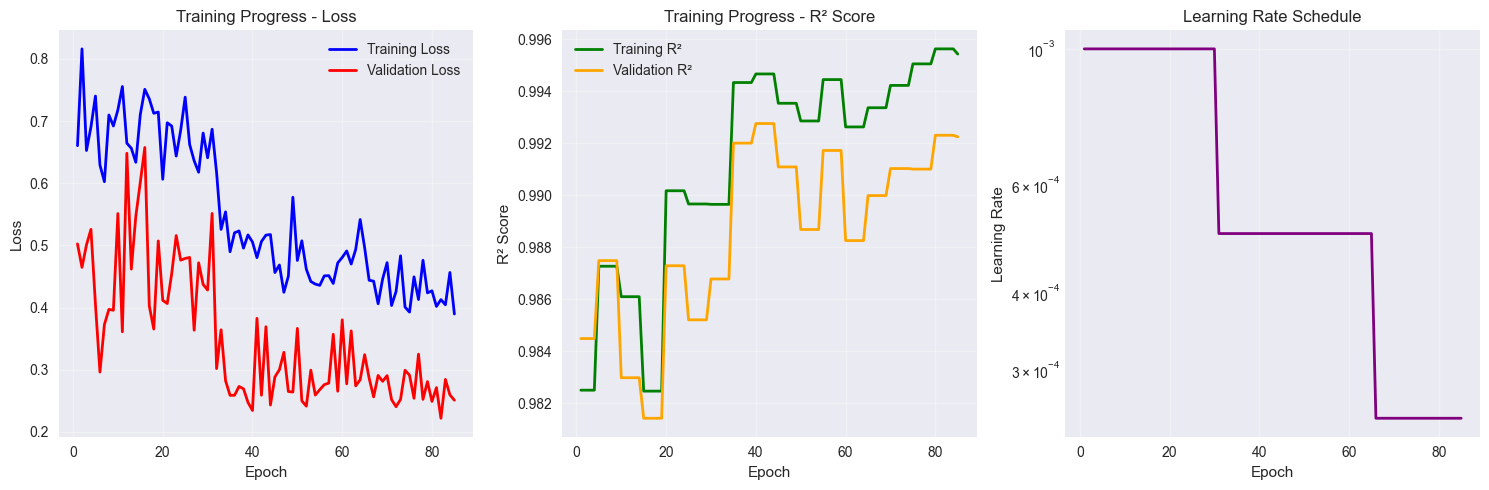

💾 Results saved:
   • Training history: enhanced_training_history.pt
   • Model weights: enhanced_trained_model.pth

📊 TRAINING SUMMARY:
   • Total epochs trained: 85
   • Final training R²: 0.9954
   • Final validation R²: 0.9923
   • Best validation R²: 0.9928
   • Training improvement: ✅ Success!


In [26]:
# 🚀 READY-TO-RUN: Enhanced Training with Early Stopping
# This cell is ready to run - just execute it to start enhanced training!

# Check prerequisites first
if all(var in globals() for var in ['model', 'train_loader', 'val_loader', 'device']):
    
    print("🎯 Starting Enhanced Training with Early Stopping...")
    print("⚙️  Configuration:")
    print("   • Maximum epochs: 1000")
    print("   • Learning rate: 1e-3") 
    print("   • Early stopping patience: 50 epochs")
    print("   • Minimum improvement: 0.001")
    print("   • Monitoring: Validation R² score")
    print("\n" + "="*60)
    
    # Run enhanced training
    enhanced_history = train_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        epochs=1000,        # Maximum epochs
        lr=1e-3,            # Learning rate  
        patience=50,        # Early stopping patience
        min_delta=0.001     # Minimum improvement threshold
    )
    
    print("\n" + "="*60)
    print("✅ Enhanced training completed!")
    
    # Plot training progress
    plt.figure(figsize=(15, 5))
    
    # Loss curves
    plt.subplot(1, 3, 1)
    plt.plot(enhanced_history['epochs'], enhanced_history['train_losses'], 'b-', label='Training Loss', linewidth=2)
    plt.plot(enhanced_history['epochs'], enhanced_history['val_losses'], 'r-', label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress - Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # R² curves
    plt.subplot(1, 3, 2)
    plt.plot(enhanced_history['epochs'], enhanced_history['train_r2'], 'g-', label='Training R²', linewidth=2)
    plt.plot(enhanced_history['epochs'], enhanced_history['val_r2'], 'orange', label='Validation R²', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('R² Score')
    plt.title('Training Progress - R² Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Learning rate
    plt.subplot(1, 3, 3)
    plt.plot(enhanced_history['epochs'], enhanced_history['learning_rates'], 'purple', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Save enhanced training results
    torch.save(enhanced_history, 'enhanced_training_history.pt')
    torch.save(model.state_dict(), 'enhanced_trained_model.pth')
    
    print(f"💾 Results saved:")
    print(f"   • Training history: enhanced_training_history.pt")
    print(f"   • Model weights: enhanced_trained_model.pth")
    
    # Summary
    final_train_r2 = enhanced_history['train_r2'][-1]
    final_val_r2 = enhanced_history['val_r2'][-1]
    best_val_r2 = max(enhanced_history['val_r2'])
    total_epochs = len(enhanced_history['epochs'])
    
    print(f"\n📊 TRAINING SUMMARY:")
    print(f"   • Total epochs trained: {total_epochs}")
    print(f"   • Final training R²: {final_train_r2:.4f}")
    print(f"   • Final validation R²: {final_val_r2:.4f}")
    print(f"   • Best validation R²: {best_val_r2:.4f}")
    print(f"   • Training improvement: {'✅ Success!' if final_val_r2 > 0.7 else '⚠️ May need more tuning'}")
    
else:
    print("❌ Prerequisites not met!")
    print("Please run the data loading cell first to ensure:")
    print("   • model is loaded")
    print("   • train_loader and val_loader are available")
    print("   • device is set")
    print("\nThen come back and run this cell again.")